In [4]:
### Paquetes y Base de datos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from scipy.stats import genpareto, invgamma, lognorm, gaussian_kde
import scipy.stats as st
import os
from sklearn.neighbors import KernelDensity

df = pd.read_csv(r"..\data\clean\datos_limpios_log.csv").drop(columns=["Unnamed: 0"])


# Funciones

In [5]:
def umbral_optimo (datos, ventana = 5, metodo = 'centro', categoria = None, provincia = None, sector = None, canton = None):

    if categoria is not None and provincia is None and sector is None and canton is None:
        datos_cat = np.array(datos[datos['categoria'] == categoria]['total'])
        titulo = f" | Categoría : {categoria}"
        nombre_cat = categoria

    elif provincia is not None and categoria is None and sector is None and canton is None:
        datos_cat = np.array(datos[datos['provincia'] == provincia]['total'])
        titulo = f" | Provincia : {provincia}"
        nombre_cat = provincia

    elif sector is not None and categoria is None and provincia is None and canton is None:
        datos_cat = np.array(datos[datos['sector'] == sector]['total'])
        titulo = f" | Sector : {sector}"
        nombre_cat = sector

    elif canton is not None and categoria is None and provincia is None and sector is None:
        datos_cat = np.array(datos[datos['canton'] == canton]['total'])
        titulo = f" | Cantón : {canton}"
        nombre_cat = canton

    elif provincia is None and categoria is None and sector is None and canton is None:
        datos_cat = np.array(datos['total'])
        titulo = ''
        nombre_cat = 'global'

    else:
        raise ValueError("Debe especificar solo una variable entre: categoria, provincia, sector o canton.")

    umbrales = np.linspace(np.percentile(datos_cat, 50), np.percentile(datos_cat, 99), 1000)
    mrl = []
    umbrales_ok = []

    for u in umbrales:
        exc = datos_cat[datos_cat > u] - u
        prop = len(exc) / len(datos_cat)
        if 0.05 <= prop <= 0.20:
            mrl.append(exc.mean() if len(exc) else np.nan)
            umbrales_ok.append(u)
        else:
            mrl.append(np.nan)
            umbrales_ok.append(np.nan)

    mrl = np.array(mrl)
    t = np.array(umbrales)
    valid = ~np.isnan(mrl)
    t = t[valid]
    mrl = mrl[valid]

    if len(mrl) < ventana:
        u_fallback = np.percentile(datos_cat, 90)
        print("[Aviso] MRL con pocos puntos válidos. Uso fallback p90 =", f"{u_fallback:,.2f}")
        return float(u_fallback)

    min_var = np.inf
    idx_best = None
    for i in range(len(mrl) - ventana + 1):
        ventana_vals = mrl[i:i+ventana]
        var = np.var(ventana_vals)
        if var < min_var:
            min_var = var
            idx_best = i

    idx_ventana = idx_best
    ventana_umbral = t[idx_ventana:idx_ventana+ventana]

    if metodo == 'centro':
        umbral_opt = ventana_umbral[ventana // 2]
    elif metodo == 'promedio':
        umbral_opt = ventana_umbral.mean()
    else:
        raise ValueError("Método debe ser 'centro' o 'promedio'")

    num_cola = np.sum(datos_cat > umbral_opt)
    porc_cola = num_cola / len(datos_cat) * 100
    if categoria is not None and provincia is None and sector is None:
        print('El úmbral óptimo para', categoria, 'es', f"{umbral_opt:.3f}")
        print(f"Número de datos en la cola: {num_cola}")
        print(f"Porcentaje de datos en la cola: {porc_cola:.2f}%")
    if provincia is not None and categoria is None and sector is None:
        print('El úmbral óptimo para', provincia, 'es', f"{umbral_opt:.3f}")
        print(f"Número de datos en la cola: {num_cola}")
        print(f"Porcentaje de datos en la cola: {porc_cola:.2f}%")
    if sector is not None and categoria is None and provincia is None:
        print('El úmbral óptimo para', sector, 'es', f"{umbral_opt:.3f}")
        print(f"Número de datos en la cola: {num_cola}")
        print(f"Porcentaje de datos en la cola: {porc_cola:.2f}%")

    plt.figure(figsize=(8,5))
    plt.plot(t, mrl, marker='o', markersize=4, label="MRL")
    plt.axvline(umbral_opt, color="red", linestyle=":", label=f"Umbral óptimo: {umbral_opt:.2f}")
    plt.xlabel("Umbral u")
    plt.ylabel("Mean Residual Life")
    plt.title("Selección de Umbral con MRL" + titulo)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../res/figures/umbral_optimo_MRL_{nombre_cat if nombre_cat != '' else 'global'}.png")
    plt.show()

    return float(umbral_opt)






def bins_fd(x):
    x = np.asarray(x)
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    n = len(x)
    bin_width = 2 * iqr / (n ** (1 / 3))
    if bin_width == 0:
        return min(10, n)
    bins = int(np.ceil((x.max() - x.min()) / bin_width))
    return max(bins, 1)







def histogramas(datos, u, categoria=None, provincia=None, sector=None, canton = None):

    if categoria is not None and provincia is None and sector is None and canton is None:
        datos_cat = datos[datos['categoria'] == categoria]['total']
        titulo_cat = f" | Categoría: {categoria}"
        nombre_cat = categoria

    elif provincia is not None and categoria is None and sector is None and canton is None:
        datos_cat = datos[datos['provincia'] == provincia]['total']
        titulo_cat = f" | Provincia: {provincia}"
        nombre_cat = provincia

    elif sector is not None and categoria is None and provincia is None and canton is None:
        datos_cat = datos[datos['sector'] == sector]['total']
        titulo_cat = f" | Sector: {sector}"
        nombre_cat = sector

    elif canton is not None and categoria is None and provincia is None and sector is None:
        datos_cat = datos[datos['canton'] == canton]['total']
        titulo_cat = f" | Cantón: {canton}"
        nombre_cat = canton

    elif provincia is None and categoria is None and sector is None and canton is None:
        datos_cat = datos['total']
        titulo_cat = ""
        nombre_cat = "global"

    else:
        raise ValueError("Solo se debe especificar una entre categoria, provincia, sector o canton.")

    n_total = len(datos_cat)
    cuerpo = datos_cat[datos_cat <= u]
    cola = datos_cat[datos_cat > u]
    n_cuerpo = len(cuerpo)
    n_cola = len(cola)
    pct_cuerpo = n_cuerpo / n_total * 100
    pct_cola = n_cola / n_total * 100

    bins_total = bins_fd(datos_cat)
    bins_cuerpo = bins_fd(cuerpo) if len(cuerpo) > 0 else 1
    bins_cola = bins_fd(cola) if len(cola) > 0 else 1

    plt.figure(figsize=(10,5))
    sns.histplot(datos_cat, bins=bins_total, color='firebrick')
    plt.title("Histograma de pérdidas totales" + titulo_cat)
    plt.xlabel("Pérdida Total (log)")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(f"../res/figures/histograma_total_{nombre_cat if nombre_cat != '' else 'global'}.png")
    plt.show()

    plt.figure(figsize=(10,5))
    sns.histplot(cuerpo, bins=bins_cuerpo, color='royalblue')
    plt.title(f"Cuerpo (≤ {u:.2f})" + titulo_cat + f" | N = {n_cuerpo} ({pct_cuerpo:.1f}%)")
    plt.xlabel("Pérdida Total (log)")
    plt.ylabel("Frecuencia")
    plt.savefig(f"../res/figures/histograma_cuerpo_{nombre_cat if nombre_cat != '' else 'global'}.png")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    sns.histplot(cola, bins=bins_cola, color='darkorange')
    plt.title(f"Cola (> {u:.2f})" + titulo_cat + f" | N = {n_cola} ({pct_cola:.1f}%)")
    plt.xlabel("Pérdida Total (log)")
    plt.ylabel("Frecuencia")
    plt.savefig(f"../res/figures/histograma_cola_{nombre_cat if nombre_cat != '' else 'global'}.png")
    plt.tight_layout()
    plt.show()


def guardar_muestras_csv(samples, model_name, model_type, u_opt, p_u, location, path="../res/mcmc"):

    os.makedirs(path, exist_ok=True)

    n_params = samples.shape[1]
    columnas = [f"{model_name}_param{i+1}" for i in range(n_params)]
    columnas += ["iteration", "model_name", "model_type", "u_opt", "p_u", "location"]

    rows = []
    for i in range(samples.shape[0]):
        row = list(samples[i]) + [i, model_name, model_type, u_opt, p_u, location]
        rows.append(row)

    df_out = pd.DataFrame(rows, columns=columnas)
    df_out.to_csv(f"{path}/{location}_{model_type}_{model_name}.csv", index=False)


def guardar_kde_csv(x_grid, dens, model_name, model_type, kernel, bw, u_opt, p_u, location, path="../res/kde"):
    os.makedirs(path, exist_ok=True)

    df_out = pd.DataFrame({
        "x": x_grid,
        "f": dens,
        "model_name": model_name,
        "model_type": model_type,
        "kernel": kernel,
        "bandwidth": bw,
        "u_opt": u_opt,
        "p_u": p_u,
        "location": location
    })

    df_out.to_csv(f"{path}/{location}_{model_type}_{model_name}_kde.csv", index=False)


In [6]:
def valida_gamma(theta, data):
    alpha, beta = theta
    return alpha > 0 and beta > 0 and np.all(data > 0)

def valida_weibull(theta, data):
    k, lam = theta
    return k > 0 and lam > 0 and np.all(data > 0)

def valida_lognorm(theta, data):
    mu, sigma = theta
    return (sigma > 0) and np.all(data > 0)

def valida_fisk(theta, data):
    alpha, beta = theta
    return (alpha > 0) and (beta > 0) and np.all(data > 0)

def valida_gpd(theta, data):
    xi, sigma = theta
    if sigma <= 0: 
        return False
    return np.all(1.0 + xi*data/sigma > 0)

def valida_burr(theta, exc):
    c, k, lam = theta
    return c > 0 and k > 0 and lam > 0

def valida_pareto(theta, exc):
    a, y0 = theta
    return a > 0 and y0 > 0

def valida_logn_tail(theta, x, u):
    mu, s = theta
    return s > 0 and np.all(x > u)

def valida_pareto_max(theta, data):
    a, y0 = theta
    data = np.asarray(data)
    return (a > 0) and (y0 > 0) and np.all(data >= y0)

In [7]:
def logpost_gamma(theta, data):
    alpha, beta = theta
    if alpha <= 0 or beta <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.gamma.logpdf(data, a=alpha, scale=1.0/beta))
    lp = st.expon.logpdf(alpha, scale=10) + st.expon.logpdf(beta, scale=10)
    return ll + lp

def logpost_weibull(theta, data):
    k, lam = theta
    if k <= 0 or lam <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.weibull_min.logpdf(data, c=k, scale=lam))
    lp = st.expon.logpdf(k, scale=10) + st.expon.logpdf(lam, scale=10)
    return ll + lp

def logpost_lognorm(theta, data):
    mu, sigma = theta
    if sigma <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.lognorm.logpdf(data, s=sigma, scale=np.exp(mu)))
    lp = st.norm.logpdf(mu, 0, 10) + st.halfnorm.logpdf(sigma, scale=5)
    return ll + lp

def logpost_fisk(theta, data):
    alpha, beta = theta
    if alpha <= 0 or beta <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.fisk.logpdf(data, c=alpha, scale=beta))
    lp = st.expon.logpdf(alpha, scale=10) + st.expon.logpdf(beta, scale=10)
    return ll + lp

def logpost_gpd(theta, data):
    xi, sigma = theta
    if sigma <= 0 or np.any(1.0 + xi*data/sigma <= 0):
        return -np.inf
    ll = np.sum(st.genpareto.logpdf(data, c=xi, scale=sigma))
    lp = st.norm.logpdf(xi, 0, 1) + st.expon.logpdf(sigma, scale=1)
    return ll + lp

def logpost_burr(theta, exc):
    c, k, lam = theta
    if c <= 0 or k <= 0 or lam <= 0:
        return -np.inf
    return (
        np.sum(st.burr12.logpdf(exc, c=c, d=k, scale=lam))
        + st.expon.logpdf(c, scale=10)
        + st.expon.logpdf(k, scale=10)
        + st.expon.logpdf(lam, scale=10)
    )

def logpost_pareto(theta, exc):
    a, y0 = theta
    if a <= 0 or y0 <= 0:
        return -np.inf
    ll = np.sum(np.log(a) + a*np.log(y0) - (a+1)*np.log(exc + y0))
    lp = st.expon.logpdf(a, scale=10) + st.expon.logpdf(y0, scale=10)
    return ll + lp

def logpost_logn_tail(theta, x, u):
    mu, s = theta
    if s <= 0 or np.any(x <= u):
        return -np.inf
    Z = 1 - st.lognorm.cdf(u, s=s, scale=np.exp(mu))
    if Z <= 0:
        return -np.inf
    return (
        np.sum(st.lognorm.logpdf(x, s=s, scale=np.exp(mu)) - np.log(Z))
        + st.norm.logpdf(mu, 0, 10)
        + st.halfnorm.logpdf(s, scale=5)
    )

def logpost_pareto_max(theta, data):
    a, y0 = theta
    data = np.asarray(data)
    if a <= 0 or y0 <= 0 or np.any(data < y0):
        return -np.inf
    ll = len(data) * np.log(a) + len(data) * a * np.log(y0) - (a + 1) * np.sum(np.log(data))
    lp = st.expon.logpdf(a, scale=10) + st.expon.logpdf(y0, scale=10)
    return ll + lp

def cdf_body_factory(model, params):
    if model == "Lognormal":
        mu, s = params
        return lambda x: st.lognorm.cdf(x, s=s, scale=np.exp(mu))
    if model == "Weibull":
        k, lam = params
        return lambda x: st.weibull_min.cdf(x, c=k, scale=lam)
    if model == "Gamma":
        a, b = params
        return lambda x: st.gamma.cdf(x, a=a, scale=1/b)
    if model == "Fisk":
        a, b = params
        return lambda x: st.fisk.cdf(x, c=a, scale=b)
    if model == "Pareto_max":
        a, y0 = params
        return lambda x: 1 - (y0 / x)**a * (x >= y0)
    raise ValueError("Modelo de cuerpo no reconocido.")

In [8]:
def waic(log_lik_matrix):
    a = np.max(log_lik_matrix, axis=0, keepdims=True)
    lppd = np.sum(a + np.log(np.mean(np.exp(log_lik_matrix - a), axis=0, keepdims=True)))
    p_waic = np.sum(np.var(log_lik_matrix, axis=0, ddof=1))
    return -2*(lppd - p_waic)

def waic_gamma(samples, data):
    S = samples.shape[0]
    N = data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        a, b = samples[s]
        ll[s] = st.gamma.logpdf(data, a=a, scale=1.0/b)
    return waic(ll), ll

def waic_weibull(samples, data):
    S = samples.shape[0]; N = data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        k, lam = samples[s]
        ll[s] = st.weibull_min.logpdf(data, c=k, scale=lam)
    return waic(ll), ll

def waic_lognorm(samples, data):
    S, N = samples.shape[0], data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        mu, sig = samples[s]
        ll[s] = st.lognorm.logpdf(data, s=sig, scale=np.exp(mu))
    return waic(ll), ll

def waic_fisk(samples, data):
    S, N = samples.shape[0], data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        a, b = samples[s]
        ll[s] = st.fisk.logpdf(data, c=a, scale=b)
    return waic(ll), ll

def waic_gpd(samples, data):
    S = samples.shape[0]; N = data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        xi, sigma = samples[s]
        ll[s] = st.genpareto.logpdf(data, c=xi, scale=sigma)
    return waic(ll), ll

def waic_burr(samples, exc):
    S, N = samples.shape[0], exc.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        c, k, lam = samples[s]
        ll[s] = st.burr12.logpdf(exc, c=c, d=k, scale=lam)
    return waic(ll), ll

def waic_pareto(samples, exc):
    S, N = samples.shape[0], exc.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        a, y0 = samples[s]
        ll[s] = np.log(a) + a*np.log(y0) - (a+1)*np.log(exc + y0)
    return waic(ll), ll

def waic_logn_tail(samples, x, u):
    S, N = samples.shape[0], x.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        mu, sig = samples[s]
        Z = 1 - st.lognorm.cdf(u, s=sig, scale=np.exp(mu))
        ll[s] = st.lognorm.logpdf(x, s=sig, scale=np.exp(mu)) - np.log(Z)
    return waic(ll), ll

def waic_pareto_max(samples, data):
    S, N = samples.shape[0], data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        a, y0 = samples[s]
        ll[s] = np.log(a) + a * np.log(y0) - (a + 1) * np.log(data)
    return waic(ll), ll


def dic_from_ll(log_lik_matrix):
    elpd = -np.mean(np.sum(log_lik_matrix, axis=1))
    a = np.max(log_lik_matrix, axis=0, keepdims=True)
    lppd = np.sum(a + np.log(np.mean(np.exp(log_lik_matrix - a), axis=0, keepdims=True)))
    p_D = 2*(lppd - (-elpd))
    return 2*elpd + p_D

def ks_ad_test(data, cdf_fn, ad_dist='norm', threshold=0.05):
    data = np.sort(data)
    ks_result = st.kstest(data, lambda t: cdf_fn(t))
    ks_p = ks_result.pvalue

    if ks_p < threshold:
        print(f"[Alerta] p-valor de KS es bajo: {ks_p:.4f}. El ajuste podría no ser bueno.")
    return ks_p

In [9]:
def metro(data, logpost, inicial, prop, n=20000, validator=None, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    d = len(inicial)
    theta = np.zeros((n, d))
    theta[0] = inicial
    acept = 0

    for i in range(1, n):
        propuesta = theta[i-1] + rng.normal(0, prop, d)

        if validator is not None and not validator(propuesta, data):
            theta[i] = theta[i-1]
            continue

        lp_new = logpost(propuesta, data)
        lp_old = logpost(theta[i-1], data)

        log_alpha = lp_new - lp_old
        if np.log(rng.random()) < log_alpha:
            theta[i] = propuesta
            acept += 1
        else:
            theta[i] = theta[i-1]

    return theta, acept/(n-1)

def traceplot(samples, names=None, burn=0):
    if names is None:
        names = [f"θ{i+1}" for i in range(samples.shape[1])]
    num_params = samples.shape[1]
    fig, axes = plt.subplots(num_params, 1, figsize=(12, 3*num_params))
    if num_params == 1:
        axes = [axes]
    for i in range(num_params):
        axes[i].plot(samples[burn:, i], linewidth=0.7)
        axes[i].set_title(f"Trayectoria del parámetro: {names[i]}")
        axes[i].set_xlabel("Iteración")
        axes[i].set_ylabel(names[i])
        axes[i].grid(True, linestyle=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

def traceplot_conjunto(samples, names=None, burn=0):
    if names is None:
        names = [f"θ{i+1}" for i in range(samples.shape[1])]
    S, d = samples.shape
    if d != 2:
        raise ValueError("El traceplot conjunto solo aplica a 2 parámetros (d=2)")
    samples_b = samples[burn:]
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    axes[0].plot(samples_b[:, 0], linewidth=0.7)
    axes[0].set_title(f"Trayectoria del parámetro: {names[0]}")
    axes[0].set_ylabel(names[0])
    axes[0].grid(True, linestyle=":", alpha=0.5)
    axes[1].plot(samples_b[:, 1], linewidth=0.7, color="tab:orange")
    axes[1].set_title(f"Trayectoria del parámetro: {names[1]}")
    axes[1].set_ylabel(names[1])
    axes[1].grid(True, linestyle=":", alpha=0.5)
    axes[2].plot(samples_b[:, 0], samples_b[:, 1], alpha=0.7)
    axes[2].set_title("Trayectoria conjunta en el espacio paramétrico")
    axes[2].set_xlabel(names[0])
    axes[2].set_ylabel(names[1])
    axes[2].grid(True, linestyle=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def fit_kde_models(data, kernels=['gaussian', 'tophat', 'epanechnikov', 'exponential'], bandwidths=None):

    if bandwidths is None:
        bandwidths = {kernel: 0.4*np.std(data) for kernel in kernels}

    results = []
    x_grid = np.linspace(data.min()-1, data.max()+1, 1000)[:, np.newaxis]
    for kernel in kernels:
        bw = bandwidths[kernel]
        kde = KernelDensity(kernel=kernel, bandwidth=bw)
        kde.fit(data[:, None])
        log_dens = kde.score_samples(data[:, None])
        pdf = np.exp(kde.score_samples(x_grid))
        loglik = np.sum(log_dens)
        k_params = 1
        aic = 2*k_params - 2*loglik
        bic = k_params*np.log(len(data)) - 2*loglik

        sim_kde = np.random.choice(x_grid[:, 0], size=len(data), p=pdf/pdf.sum())
        ks_p = st.kstest(data, lambda t: np.mean(sim_kde <= t))[1]
        ad_p = st.anderson_ksamp([data, sim_kde]).significance_level

        results.append({
            'modelo': f'KDE-{kernel}',
            'tipo': 'KDE',
            'parametros': f'bw={bw:.3f}',
            'loglik': loglik,
            'AIC': aic,
            'BIC': bic,
            'KS_p': ks_p,
            'AD_p': ad_p
        })
    return results, x_grid

def fit_parametric_models(data, modelos):
    results = []
    for name, (logpost, valid, inicial, prop, n_params, cdf_fn) in modelos.items():
        th, _ = metro(data, logpost, inicial=inicial, prop=prop, n=10000, validator=valid)
        samples = th[5000:]  # burn-in
        mean_par = samples.mean(axis=0)
        loglik = np.sum(np.log(cdf_fn(mean_par, data, pdf=True)))
        aic = 2*n_params - 2*loglik
        bic = n_params * np.log(len(data)) - 2*loglik
        # CDF para tests
        ks_p = st.kstest(data, lambda t: cdf_fn(mean_par, t))[1]
        F = np.clip(cdf_fn(mean_par, np.sort(data)), 1e-12, 1-1e-12)
        results.append({
            'modelo': name,
            'tipo': 'Paramétrico',
            'parametros': mean_par,
            'loglik': loglik,
            'AIC': aic,
            'BIC': bic,
            'KS_p': ks_p,
            'samples': samples
        })
    return results

In [ ]:
def pipeline(df, sector = None, categoria=None, provincia=None, canton = None, n_iter=40000, burn=20000, seed=None):
    rng = np.random.default_rng(seed)
    if categoria is not None and provincia is None and sector is None:
        print(f"Análisis por consenso para la categoría {categoria}")
    elif provincia is not None and categoria is None and sector is None:
        print(f"Análisis por consenso para la provincia {provincia}")
    elif sector is not None and categoria is None and provincia is None:
        print(f"Análisis por consenso para el sector {sector}")
    elif canton is not None and categoria is None and provincia is None:
        print(f"Análisis por consenso para el cantón {canton}")

    # Umbral e histogramas
    u_opt = umbral_optimo(df, categoria = categoria, provincia = provincia, sector = sector, canton = canton)
    histogramas(df, u_opt, categoria, provincia, sector, canton)

    if categoria is not None and provincia is None and sector is None:
        x = df.loc[df['categoria'] == categoria, 'total'].to_numpy()
        titulo_cat = f" | Categoría: {categoria}"
    elif provincia is not None and categoria is None and sector is None:
        x = df.loc[df['provincia'] == provincia, 'total'].to_numpy()
        titulo_cat = f" | Provincia: {provincia}"
    elif sector is not None and categoria is None and provincia is None:
        x = df.loc[df['sector'] == sector, 'total'].to_numpy()
        titulo_cat = f" | Sector: {sector}"
    elif canton is not None and categoria is None and provincia is None and sector is None:
        x = df.loc[df['canton'] == canton, 'total'].to_numpy()
        titulo_cat = f" | Cantón: {canton}"
    else:
        x = df['total'].to_numpy()

    x = x[x > 0]
    location = categoria or provincia or sector or canton or "general"

    if provincia is not None:
        base_path = "../res/provincias"
    elif categoria is not None:
        base_path = "../res/categorias"
    elif sector is not None:
        base_path = "../res/sectores"
    elif canton is not None:
        base_path = "../res/cantones"
    else:
        base_path = "../res/general"
    body = x[(x <= u_opt)]
    tail_x = x[(x > u_opt)]
    exc = tail_x - u_opt
    p_u = len(tail_x) / max(1, len(x))

    if len(body) < 20:
        print("Advertencia: muy pocos datos en el cuerpo para una selección estable.")

    # Distriubución del cuerpo
    body_models = {
        "Gamma":     (logpost_gamma,   valida_gamma,   [2.0, 0.5],                                            [0.30, 0.20], waic_gamma),
        "Weibull":   (logpost_weibull, valida_weibull, [1.0, np.median(body) if len(body)>0 else 1.0],         [0.20, 0.20], waic_weibull),
        "Lognormal": (logpost_lognorm, valida_lognorm, [np.mean(np.log(body)), np.std(np.log(body))] if len(body)>0 else [0.0,1.0], [0.10, 0.05], waic_lognorm),
        "Fisk":      (logpost_fisk,    valida_fisk,    [1.0, np.median(body) if len(body)>0 else 1.0],         [0.20, 0.20], waic_fisk),
    }

    body_metrics = []
    body_fit = {}
    for name, (logp, valid, init, step, waic_fn) in body_models.items():
        print(f"\n Ajustando cuerpo: {name}")
        th, ar = metro(body, logp, inicial=init, prop=step, n=n_iter, validator=valid, rng=rng)
        th_b = th[burn:]
        print(f"Tasa de aceptación {name}: {ar:.2f}")
        body_fit[name] = th
        w, ll = waic_fn(th_b, body)
        d = dic_from_ll(ll)
        pars_mean = th_b.mean(axis=0)
        ks_p = ks_ad_test(body, cdf_body_factory(name, pars_mean))
        body_metrics.append({
            'modelo': name,
            'tipo': 'Paramétrico',
            'parametros': pars_mean,
            'loglik': np.sum(ll.mean(axis=0)),
            'AIC': w,
            'BIC': d,
            'KS_p': ks_p
        })

    # KDE para cuerpo
    cuerpo_kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential']
    bandwidths_cuerpo = {k: 0.4 * np.std(body) for k in cuerpo_kernels}
    x_grid = np.linspace(body.min() - 1, body.max() + 1, 1000)
    for kernel in cuerpo_kernels:
        bw = bandwidths_cuerpo[kernel]
        kde = KernelDensity(kernel=kernel, bandwidth=bw)
        kde.fit(body[:, None])
        log_dens = kde.score_samples(body[:, None])
        loglik = np.sum(log_dens)
        k_params = 1
        aic = 2 * k_params - 2 * loglik
        bic = k_params * np.log(len(body)) - 2 * loglik
        pdf_grid = np.exp(kde.score_samples(x_grid[:, None]))
        sim_kde = np.random.choice(x_grid, size=len(body), p=pdf_grid/pdf_grid.sum())
        ks_p = st.kstest(body, lambda t: np.array([np.mean(sim_kde <= val) for val in t]))[1]
        body_metrics.append({
            'modelo': f'KDE-{kernel}', 'tipo': 'KDE', 'parametros': f'bw={bw:.3f}',
            'loglik': loglik, 'AIC': aic, 'BIC': bic, 'KS_p': ks_p
        })

    res_cuerpo = pd.DataFrame(body_metrics)
    res_cuerpo = res_cuerpo.sort_values(['KS_p','AIC','BIC'], ascending=[False,True,True]).reset_index(drop=True)
    best_body = res_cuerpo.loc[0, 'modelo']
    print("\nTabla completa modelos CUERPO (paramétricos + KDE):\n", res_cuerpo[['modelo', 'tipo', 'KS_p', 'AIC', 'BIC']])

    # Distribución de la cola
    tail_results = []
    if len(exc) >= 10:
        tail_models = [
            ("GPD",        logpost_gpd,        valida_gpd,        [0.1, np.mean(exc)],         [0.15,0.50], waic_gpd),
            ("Burr",       logpost_burr,       valida_burr,       [1.0, 1.0, np.median(exc)],  [0.20,0.20,0.25], waic_burr),
            ("Pareto",     logpost_pareto,     valida_pareto,     [1.0, np.median(exc)],       [0.20,0.20],    waic_pareto),
            ("Pareto_max", logpost_pareto_max, valida_pareto_max, [1.0, exc.min()],            [0.20,0.20],    waic_pareto_max),
            ("LN_tail",    logpost_logn_tail,  lambda th,d: valida_logn_tail(th, d, u_opt),[np.log(np.median(tail_x)), 1.0], [0.10,0.05], waic_logn_tail)
        ]
        for name, logp, valid, init, step, waic_fn in tail_models:
            print(f"\n Ajustando cola: {name}")
            data_tail = exc if name in ("GPD","Burr","Pareto") else tail_x
            validator_fn = valid if name != "LN_tail" else (lambda th, d: valid(th, tail_x))
            th, ar = metro(data_tail, lambda th, d: logp(th, d if name != "LN_tail" else tail_x, u_opt) if name == "LN_tail" else logp(th, d),
                          inicial=init, prop=step, n=n_iter, validator=validator_fn, rng=rng)
            if 'tail_fit' not in locals():
                tail_fit = {}
            tail_fit[name] = th
            print(f"Tasa aceptación {name}: {ar:.2f}")
            th_b = th[burn:]
            w, ll = (waic_fn(th_b, data_tail) if name!="LN_tail" else waic_fn(th_b, tail_x, u_opt))
            if name == "GPD":
                xi, sg = th_b.mean(axis=0)
                cdf_fn = lambda t: st.genpareto.cdf(t, c=xi, scale=sg); data_check = exc
            elif name == "Burr":
                c,k,lam = th_b.mean(axis=0)
                cdf_fn = lambda t: st.burr12.cdf(t, c=c, d=k, scale=lam); data_check = exc
            elif name == "Pareto":
                a, y0 = th_b.mean(axis=0)
                cdf_fn = lambda t: 1 - (y0/(t+y0))**a; data_check = exc
            else: 
                mu,sig = th_b.mean(axis=0)
                Zu = 1 - st.lognorm.cdf(u_opt, s=sig, scale=np.exp(mu))
                cdf_ln_trunc = lambda xx: (st.lognorm.cdf(xx, s=sig, scale=np.exp(mu)) -
                                           st.lognorm.cdf(u_opt, s=sig, scale=np.exp(mu))) / Zu
                cdf_fn = cdf_ln_trunc; data_check = tail_x
            ks_p = ks_ad_test(data_check, cdf_fn)
            tail_results.append({
                'modelo': name, 'tipo': 'Paramétrico',
                'parametros': th_b.mean(axis=0),
                'loglik': np.sum(ll.mean(axis=0)),
                'AIC': w, 'BIC': w, 'KS_p': ks_p
            })
        # KDE para cola
        cola_kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential']
        bandwidths_cola = {k: 0.4 * np.std(exc) for k in cola_kernels}
        x_grid_cola = np.linspace(exc.min() - 1, exc.max() + 1, 1000)
        for kernel in cola_kernels:
            bw = bandwidths_cola[kernel]
            kde = KernelDensity(kernel=kernel, bandwidth=bw)
            kde.fit(exc[:, None])
            log_dens = kde.score_samples(exc[:, None])
            loglik = np.sum(log_dens)
            k_params = 1
            aic = 2 * k_params - 2 * loglik
            bic = k_params * np.log(len(exc)) - 2 * loglik
            pdf_grid = np.exp(kde.score_samples(x_grid_cola[:, None]))
            sim_kde = np.random.choice(x_grid_cola, size=len(exc), p=pdf_grid/pdf_grid.sum())
            ks_p = st.kstest(body, lambda t: np.array([np.mean(sim_kde <= val) for val in t]))[1]
            tail_results.append({
                'modelo': f'KDE-{kernel}', 'tipo': 'KDE', 'parametros': f'bw={bw:.3f}',
                'loglik': loglik, 'AIC': aic, 'BIC': bic, 'KS_p': ks_p
            })
        res_cola = pd.DataFrame(tail_results)
        res_cola = res_cola.sort_values(['KS_p','AIC','BIC'], ascending=[False,True,True]).reset_index(drop=True)
        best_tail = res_cola.loc[0, 'modelo']
        print("\nTabla completa modelos COLA (paramétricos + KDE):\n", res_cola[['modelo', 'tipo', 'KS_p', 'AIC', 'BIC']])
    else:
        print("Cola insuficiente. Se omite selección de cola.")
        res_cola = pd.DataFrame()
        best_tail = None

    print(f"\nModelo para cuerpo seleccionado: {best_body}")
    print(f"Modelo para cola seleccionado: {best_tail}")

    plt.figure(figsize=(9,4))
    sns.histplot(body, bins=30, stat='density', color='skyblue', edgecolor='black', label="Datos cuerpo")
    xx = np.linspace(body.min(), body.max(), 500)
    if best_body.startswith("KDE-"):
        kernel = best_body[4:]
        bw = float(res_cuerpo.loc[res_cuerpo.modelo == best_body, 'parametros'].iloc[0].split("=")[1])
        kde = KernelDensity(kernel=kernel, bandwidth=bw)
        kde.fit(body[:,None])
        dens = np.exp(kde.score_samples(xx[:,None]))
    else:
        pars = res_cuerpo.loc[res_cuerpo.modelo == best_body, 'parametros'].iloc[0]
        dens = cdf_body_factory(best_body, pars)
        dens = np.gradient(dens(xx), xx)
    plt.plot(xx, dens, lw=2, label=f"{best_body}")
    plt.title("Cuerpo" + titulo_cat)
    plt.savefig(f"../res/figures/cuerpo_{location}.png")
    plt.legend(); plt.tight_layout(); plt.show()

    if len(exc)>0:
        plt.figure(figsize=(9,4))
        sns.histplot(exc, bins=30, stat='density', color='orange', edgecolor='black', label="Excesos cola (X-u)")
        xx_c = np.linspace(exc.min(), exc.max(), 500)
        if best_tail and best_tail.startswith("KDE-"):
            kernel = best_tail[4:]
            bw = float(res_cola.loc[res_cola.modelo == best_tail, 'parametros'].iloc[0].split("=")[1])
            kde = KernelDensity(kernel=kernel, bandwidth=bw)
            kde.fit(exc[:,None])
            dens = np.exp(kde.score_samples(xx_c[:,None]))
        elif best_tail:
            pars = res_cola.loc[res_cola.modelo == best_tail, 'parametros'].iloc[0]
            if best_tail=="GPD":
                xi, sg = pars; dens = st.genpareto.pdf(xx_c, c=xi, scale=sg)
            elif best_tail=="Burr":
                c,k,lam = pars; dens = st.burr12.pdf(xx_c, c=c, d=k, scale=lam)
            elif best_tail=="Pareto":
                a,y0=pars; dens = a*y0**a/(xx_c+y0)**(a+1)
            elif best_tail=="Pareto_max":
                a,y0=pars; dens = a*y0**a/(xx_c+y0)**(a+1)
            elif best_tail=="LN_tail":
                mu,sig=pars
                Zu = 1 - st.lognorm.cdf(u_opt, s=sig, scale=np.exp(mu))
                dens = st.lognorm.pdf(xx_c+u_opt, s=sig, scale=np.exp(mu))/Zu
            else:
                dens = None
        else:
            dens = None
        if dens is not None:
            plt.plot(xx_c, dens, lw=2, label=f"{best_tail}")
        plt.title("Cola" + titulo_cat)
        plt.savefig(f"../res/figures/cola_{location}.png")
        plt.legend(); plt.tight_layout(); plt.show()

    best_body = res_cuerpo.loc[0, 'modelo']

    if not best_body.startswith("KDE-"):
        samples = body_fit[best_body]
        guardar_muestras_csv(
            samples=samples,
            model_name=best_body,
            model_type="body",
            u_opt=u_opt,
            p_u=p_u,
            location=location,
            path = base_path
        )
    else:
        kernel = best_body[4:]
        bw = float(res_cuerpo.loc[res_cuerpo.modelo == best_body, 'parametros'].iloc[0].split("=")[1])
        kde = KernelDensity(kernel=kernel, bandwidth=bw)
        kde.fit(body[:,None])
        dens = np.exp(kde.score_samples(xx[:,None]))

        guardar_kde_csv(
            x_grid=xx,
            dens=dens,
            model_name=best_body,
            model_type="body",
            kernel=kernel,
            bw=bw,
            u_opt=u_opt,
            p_u=p_u,
            location=location,
            path = base_path
        )

    best_tail = res_cola.loc[0, 'modelo']

    if best_tail and not best_tail.startswith("KDE-"):
        
        if 'tail_fit' in locals() and best_tail in tail_fit:
            samples = tail_fit[best_tail]
            guardar_muestras_csv(
                samples=samples,
                model_name=best_tail,
                model_type="tail",
                u_opt=u_opt,
                p_u=p_u,
                location=location,
                path = base_path
            )
    else:
        kernel = best_tail[4:]
        bw = float(res_cola.loc[res_cola.modelo == best_tail, 'parametros'].iloc[0].split("=")[1])
        kde = KernelDensity(kernel=kernel, bandwidth=bw)
        kde.fit(exc[:,None])
        dens = np.exp(kde.score_samples(xx_c[:,None]))

        guardar_kde_csv(
            x_grid=xx_c,
            dens=dens,
            model_name=best_tail,
            model_type="tail",
            kernel=kernel,
            bw=bw,
            u_opt=u_opt,
            p_u=p_u,
            location=location,
            path = base_path
        )




    name_map = {
        "Gamma":    ["α", "β"],
        "Weibull":  ["k", "λ"],
        "Lognormal":["μ", "σ"],
        "Fisk":     ["α", "β"],
        "GPD":      ["ξ", "σ"],
        "Burr":     ["c", "k", "λ"],
        "Pareto":   ["a", "y₀"],
        "Pareto_max":["a", "y₀"],
        "LN_tail":  ["μ", "σ"]
    }

    return {
        'u_opt': u_opt,
        'res_cuerpo': res_cuerpo,
        'res_cola': res_cola,
        'best_body': best_body,
        'best_tail': best_tail,
        'body_metrics': body_metrics,
        'tail_metrics': tail_results
    }

# Ajustes

Análisis por consenso para la categoría Hidrometereológico
El úmbral óptimo para Hidrometereológico es 21.525
Número de datos en la cola: 161
Porcentaje de datos en la cola: 7.66%


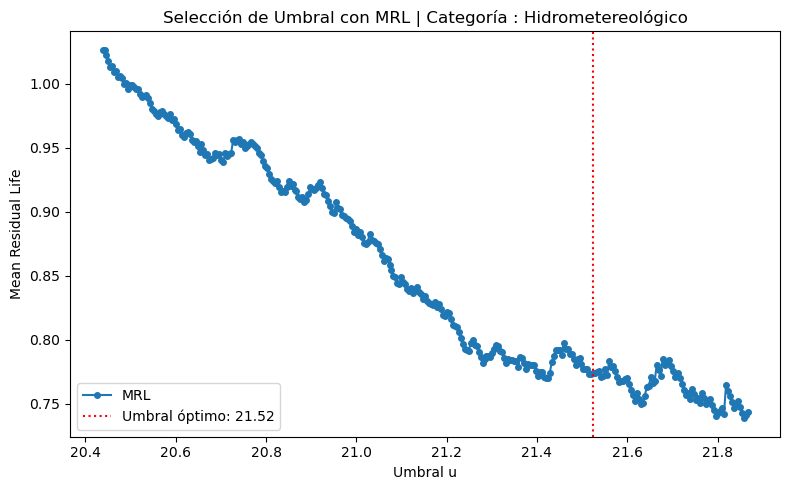

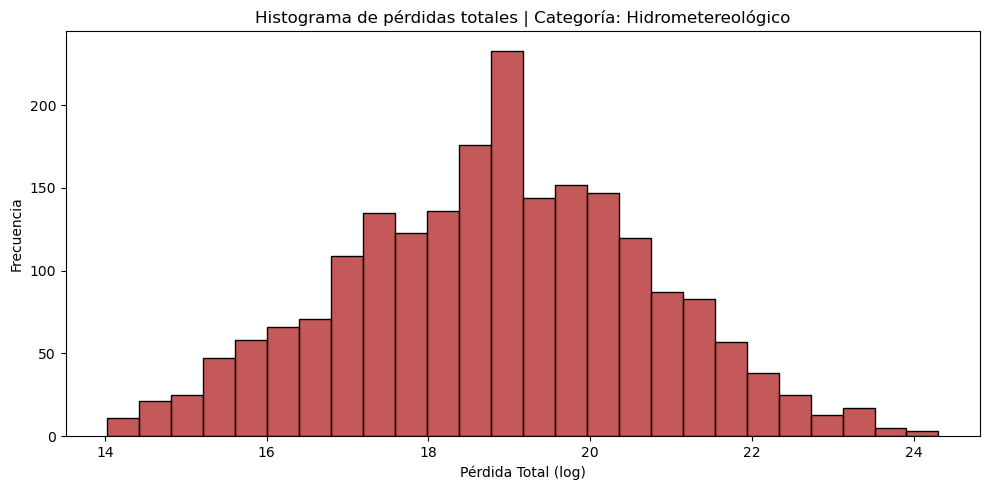

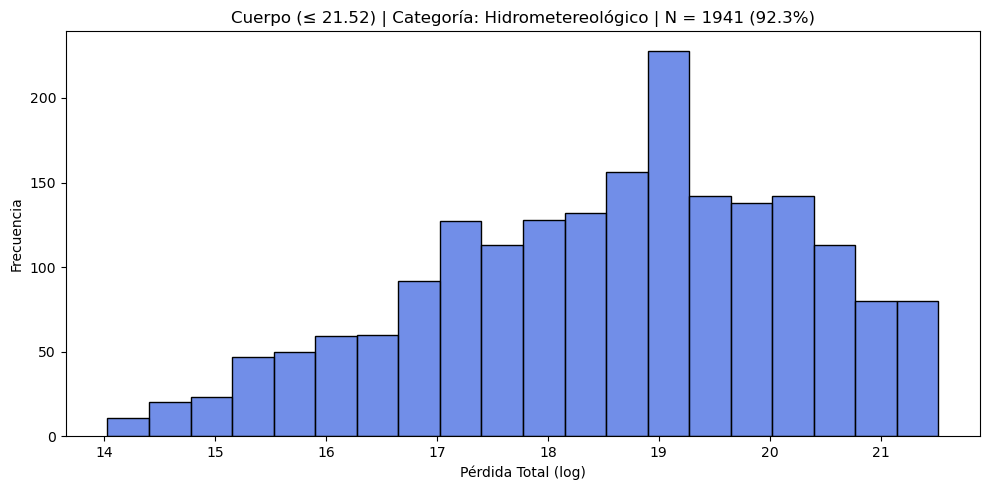

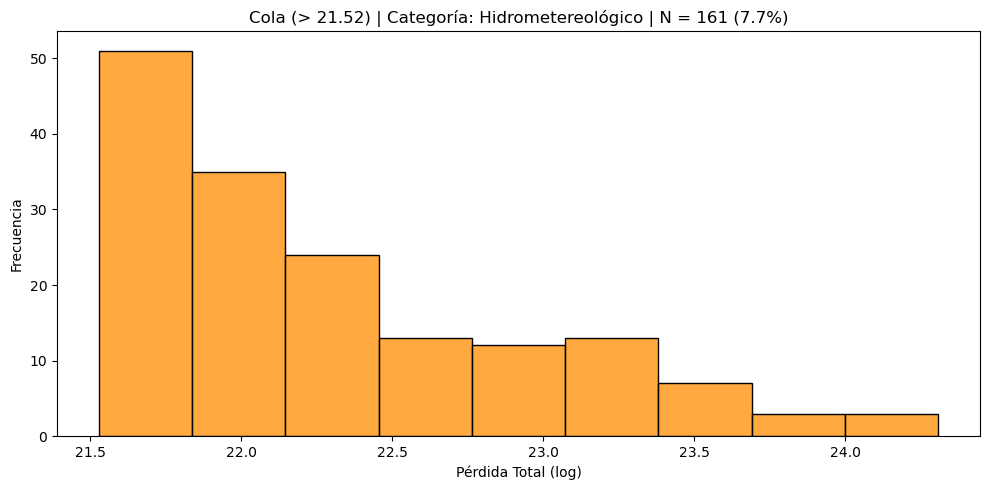


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.07
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.18
[Alerta] p-valor de KS es bajo: 0.0332. El ajuste podría no ser bueno.

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.00
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.22
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo          KS_p          AIC          BIC
0  KDE-epanechnikov          KDE  4.081221e-01  7270.451510  7276.022469
1           Weibull  Paramétrico  3.323305e-02  7388.730752  7388.726776
2        KDE-tophat          KDE  2.195904e-02  7302.403920  7307.974879
3      KDE-gaussian          KDE  5.917357e-03  7371.731760  7377.302718
4   KDE-exponential          KDE  5.519273e-04  7434.758781

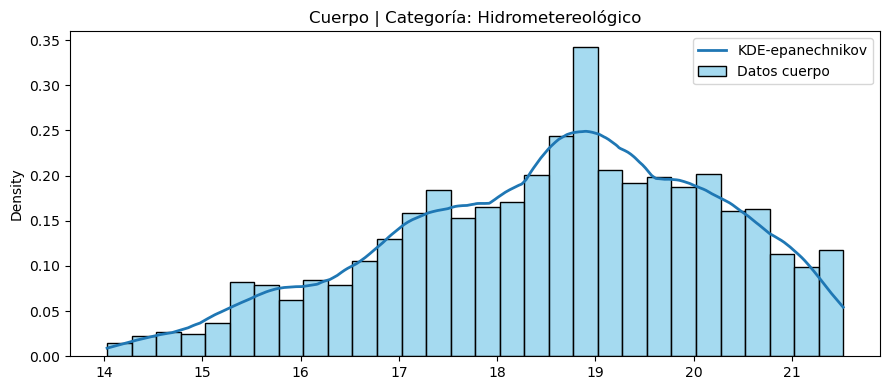

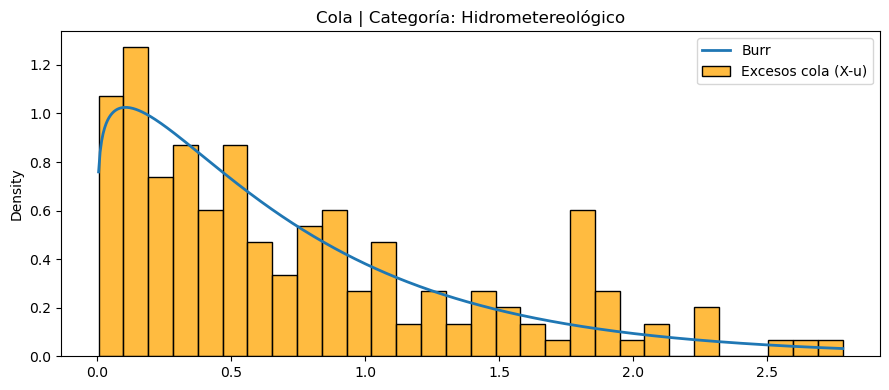

Análisis por consenso para la categoría Geológico
El úmbral óptimo para Geológico es 20.472
Número de datos en la cola: 27
Porcentaje de datos en la cola: 19.57%


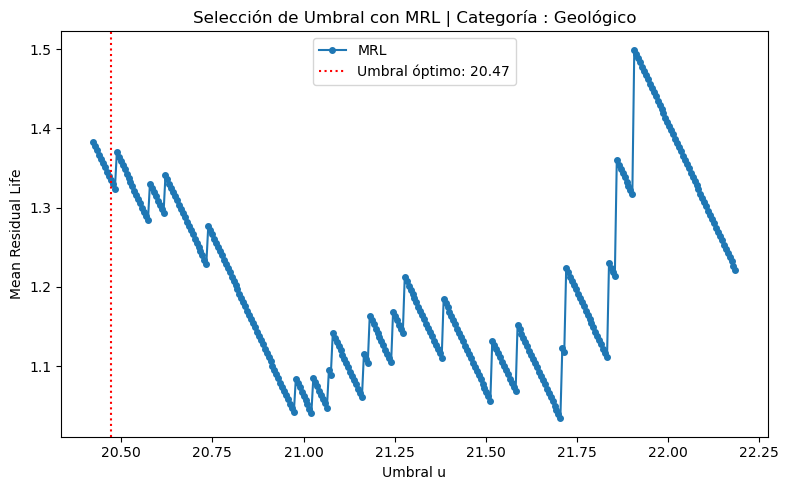

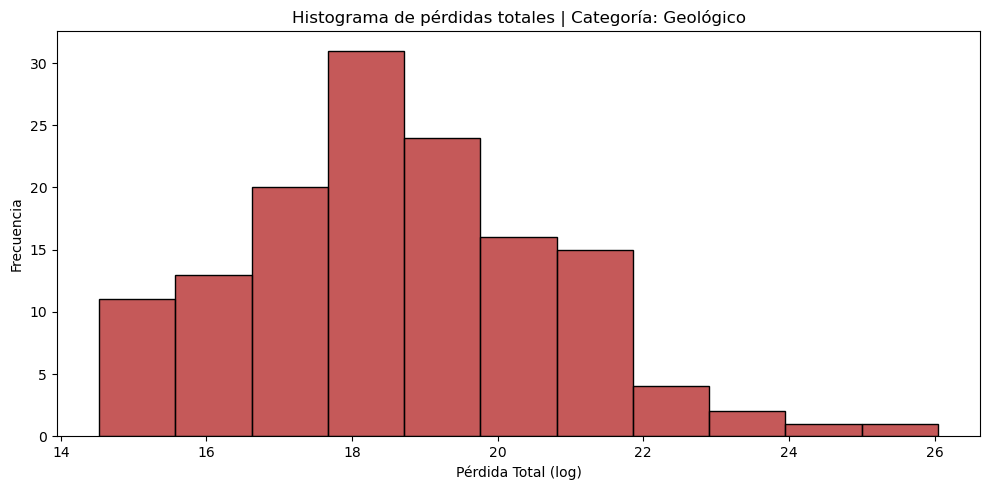

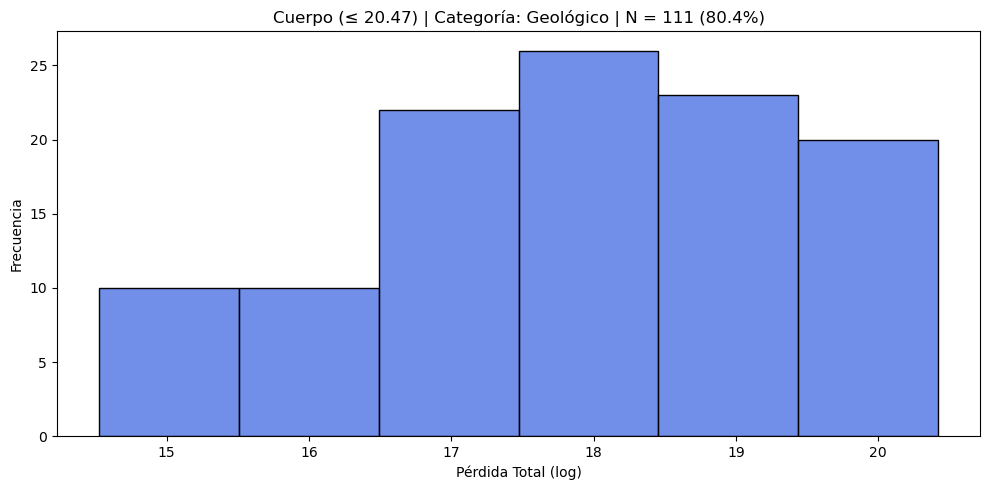

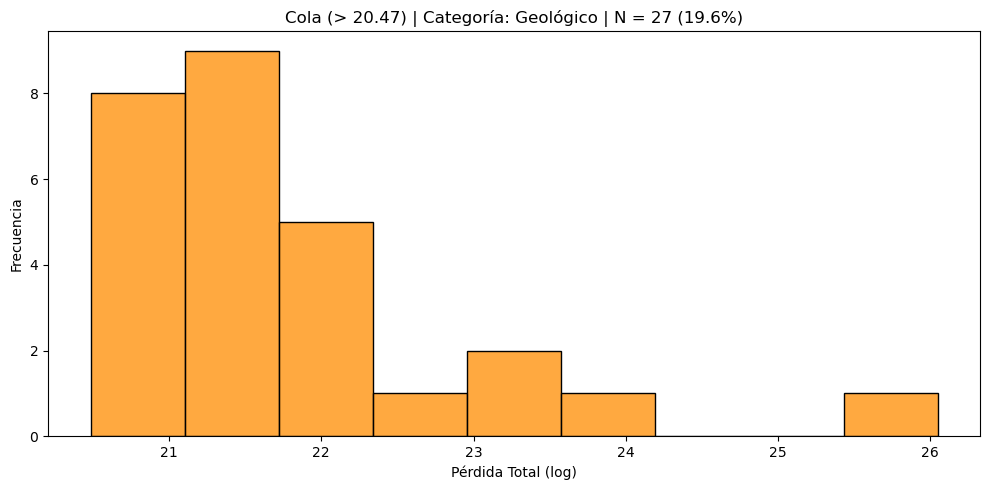


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.25

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.57

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.02

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.63

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p         AIC         BIC
0        KDE-tophat          KDE  0.884305  391.220355  393.929885
1   KDE-exponential          KDE  0.745117  401.234429  403.943959
2           Weibull  Paramétrico  0.691808  406.266979  406.214721
3              Fisk  Paramétrico  0.656258  416.230661  416.202320
4         Lognormal  Paramétrico  0.641164  411.236569  411.160579
5  KDE-epanechnikov          KDE  0.435996  390.447467  393.156997
6      KDE-gaussian          KDE  0.138682  398.980586  401.690116
7             Gamma  Paramétrico  0.076484  431.007561  430.982744

 Ajustando cola: GPD
Tasa aceptación GPD: 0.39

 Ajustando cola: Burr
Tasa aceptación Burr: 0.53

 Ajust

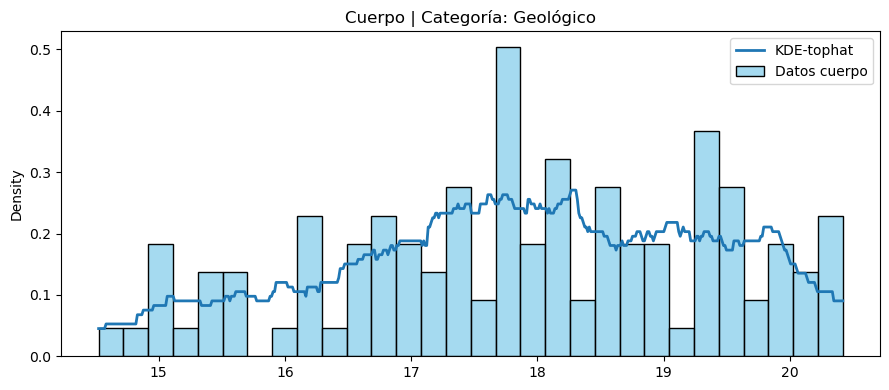

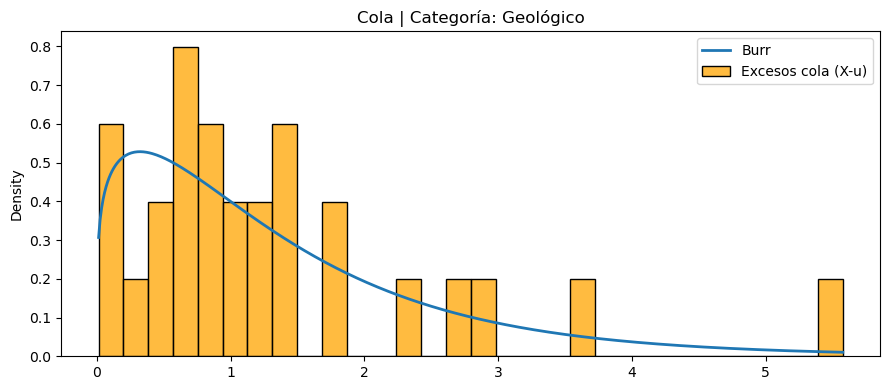

In [15]:
resultados_categoria = {}
for name in df['categoria'].unique():
    res = pipeline(df, categoria=name,n_iter=20000, burn=4000, seed=2025)

Análisis por consenso para la provincia Cartago
El úmbral óptimo para Cartago es 20.133
Número de datos en la cola: 27
Porcentaje de datos en la cola: 15.34%


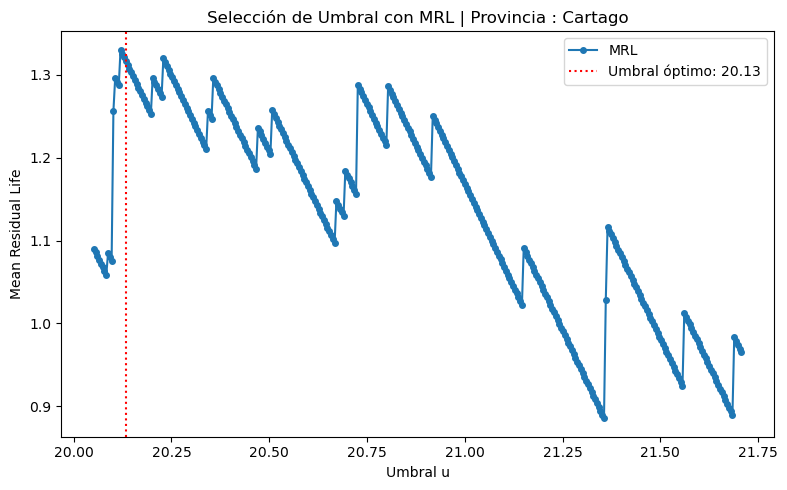

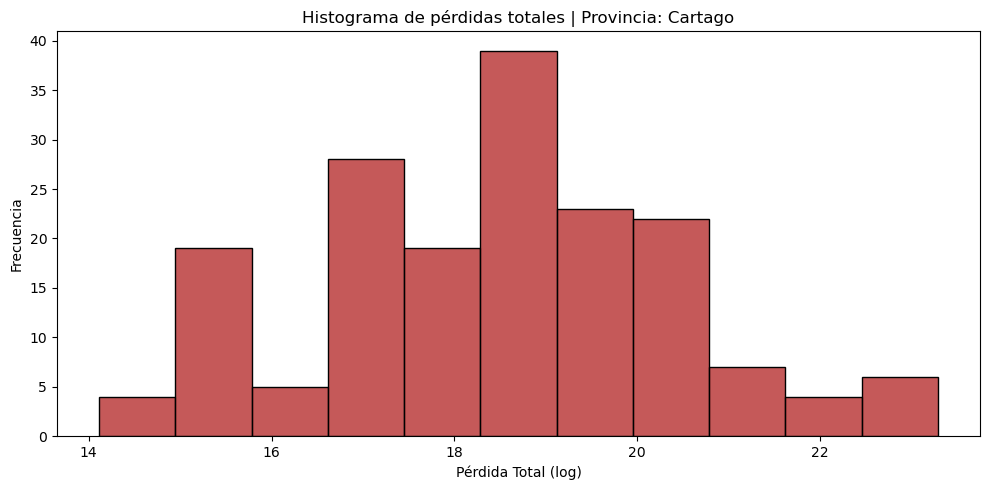

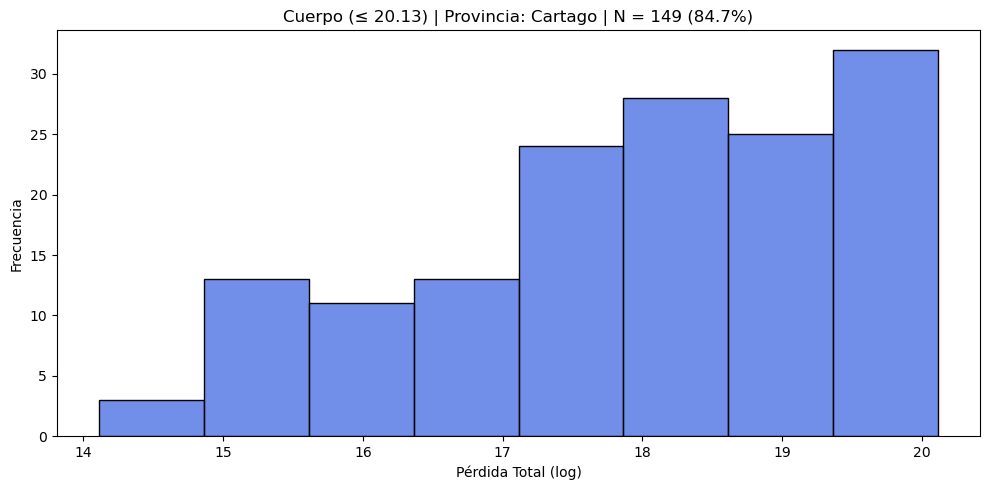

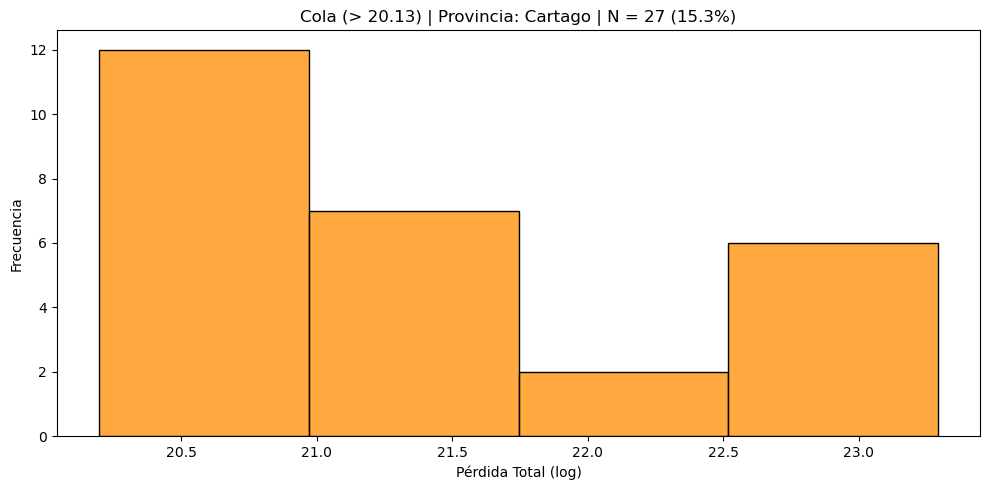


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.22
[Alerta] p-valor de KS es bajo: 0.0024. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.51

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.02
[Alerta] p-valor de KS es bajo: 0.0482. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.59

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p         AIC         BIC
0  KDE-epanechnikov          KDE  0.881768  496.587274  499.591220
1           Weibull  Paramétrico  0.353512  540.022182  539.999832
2      KDE-gaussian          KDE  0.135062  529.237903  532.241850
3   KDE-exponential          KDE  0.091022  527.918292  530.922238
4              Fisk  Paramétrico  0.072301  566.363451  566.328937
5         Lognormal  Paramétrico  0.048185  560.742252  560.688287
6        KDE-tophat          KDE  0.038089  509.269613  512.273559
7             Gamma  Paramétri

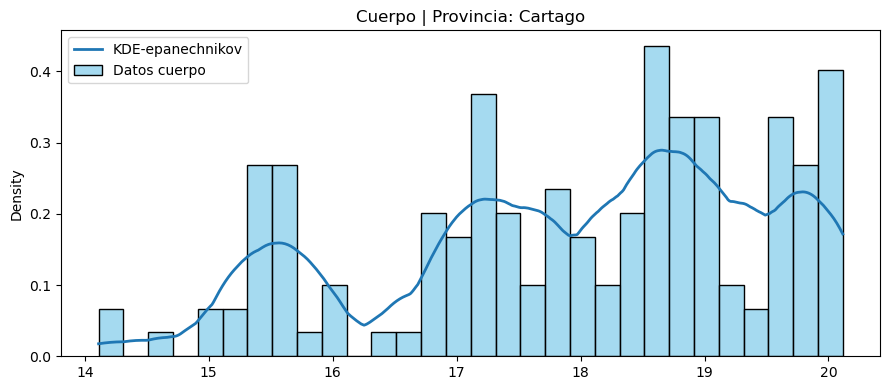

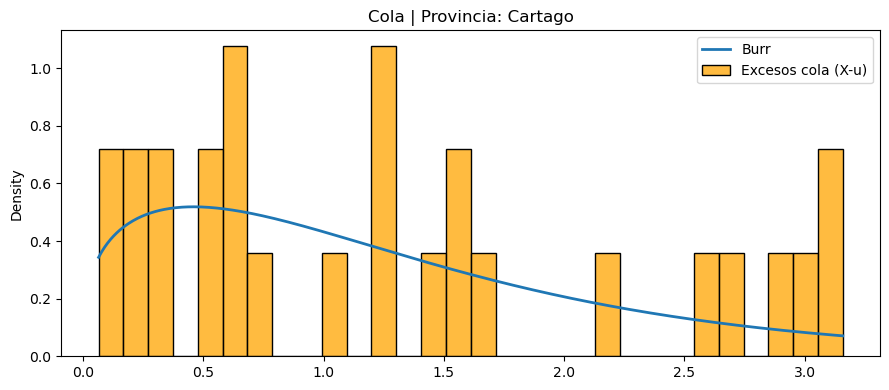

Análisis por consenso para la provincia Heredia
El úmbral óptimo para Heredia es 20.409
Número de datos en la cola: 23
Porcentaje de datos en la cola: 19.49%


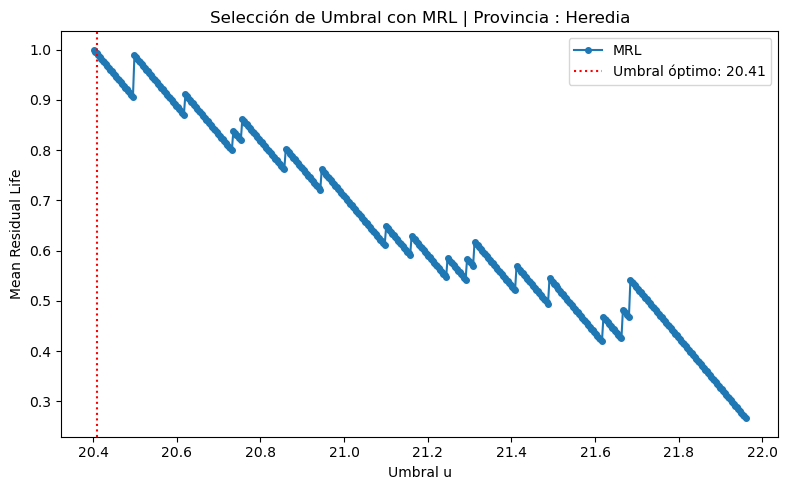

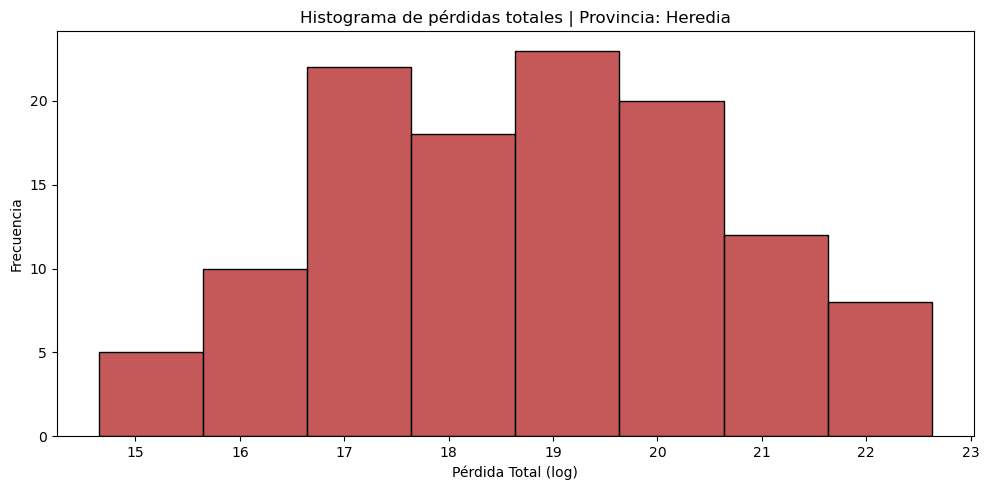

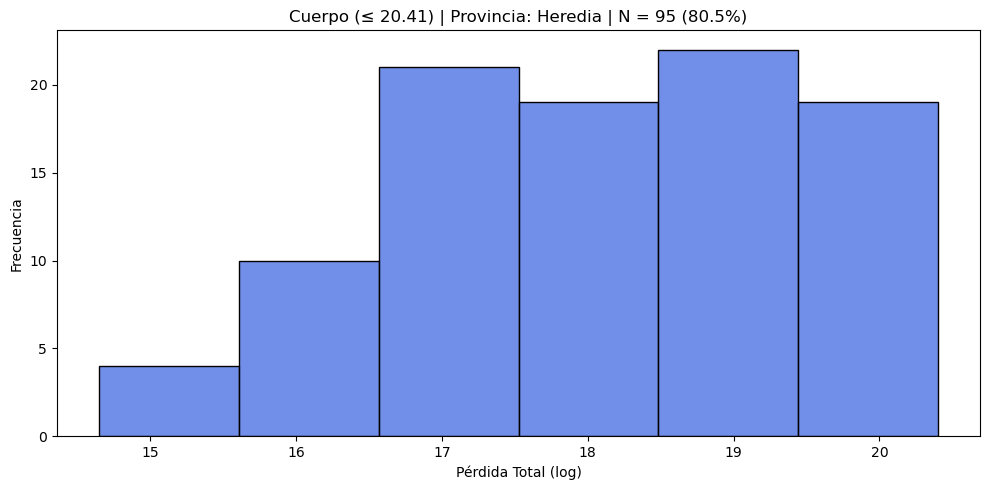

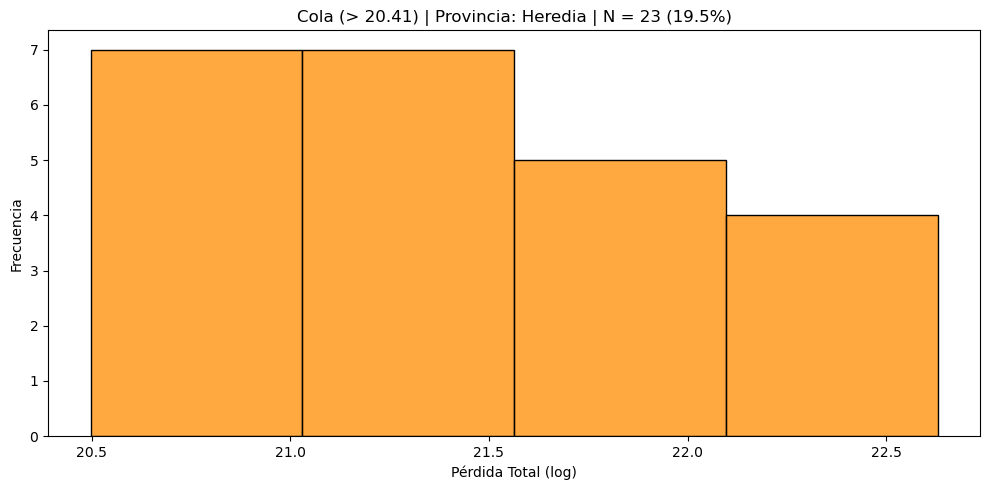


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.26
[Alerta] p-valor de KS es bajo: 0.0427. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.58

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.02

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.64

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p         AIC         BIC
0           Weibull  Paramétrico  0.417869  335.777752  335.720509
1              Fisk  Paramétrico  0.348681  343.883267  343.854017
2  KDE-epanechnikov          KDE  0.339738  317.269422  319.823298
3         Lognormal  Paramétrico  0.295007  338.325139  338.242091
4      KDE-gaussian          KDE  0.226709  327.301988  329.855865
5   KDE-exponential          KDE  0.226709  327.695584  330.249461
6        KDE-tophat          KDE  0.051666  324.863750  327.417627
7             Gamma  Paramétrico  0.042684  363.891949  363.863812

 Ajustando cola: GPD
Tasa aceptac

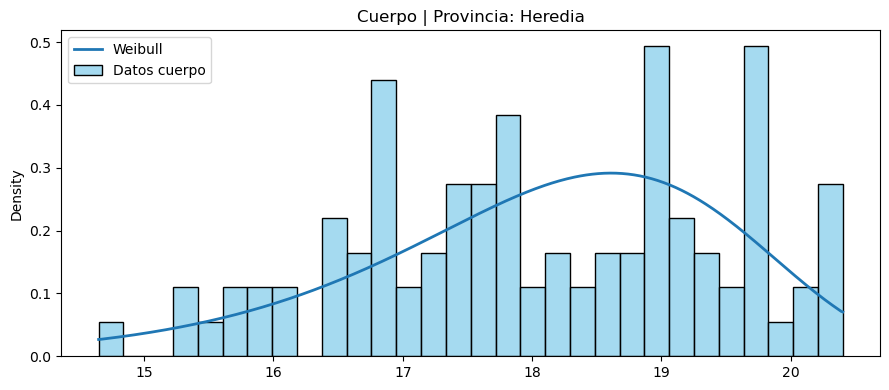

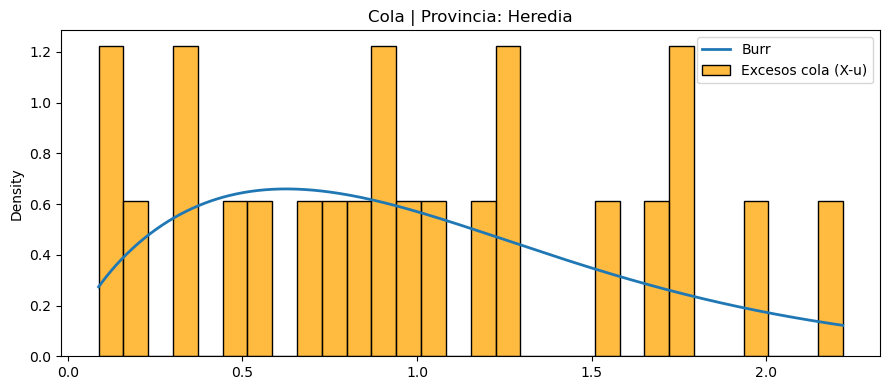

Análisis por consenso para la provincia Limón
El úmbral óptimo para Limón es 20.988
Número de datos en la cola: 38
Porcentaje de datos en la cola: 16.45%


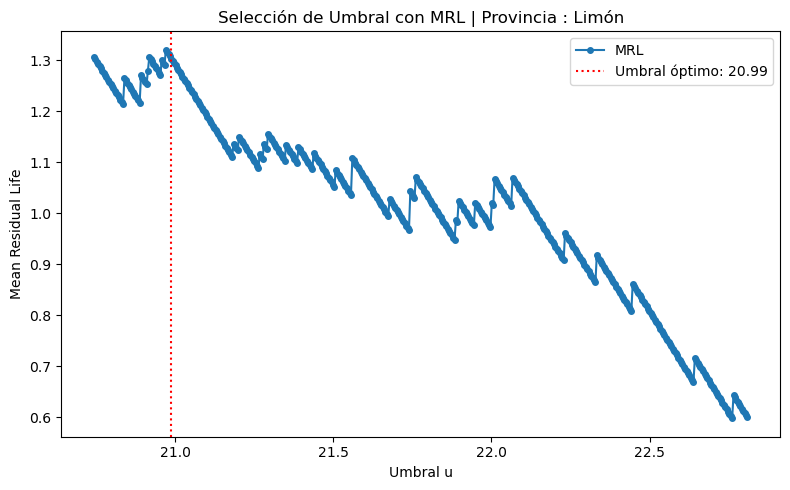

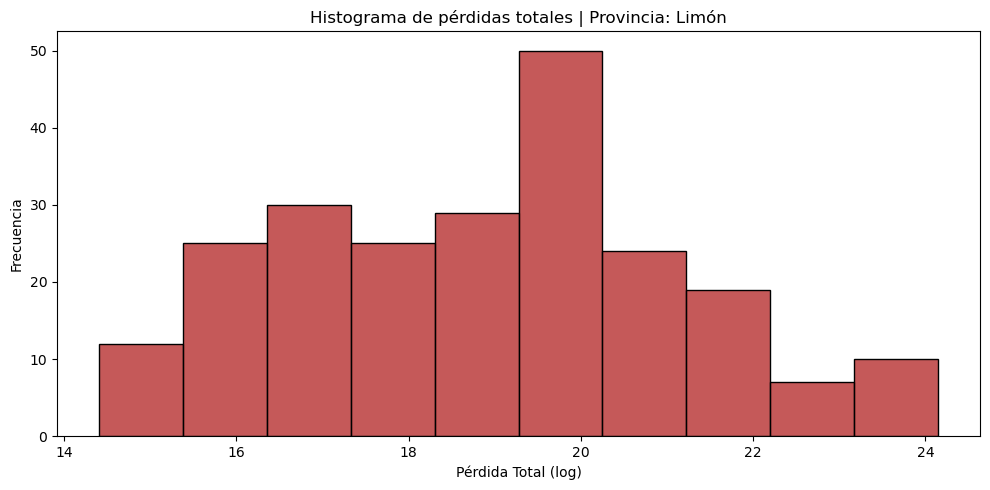

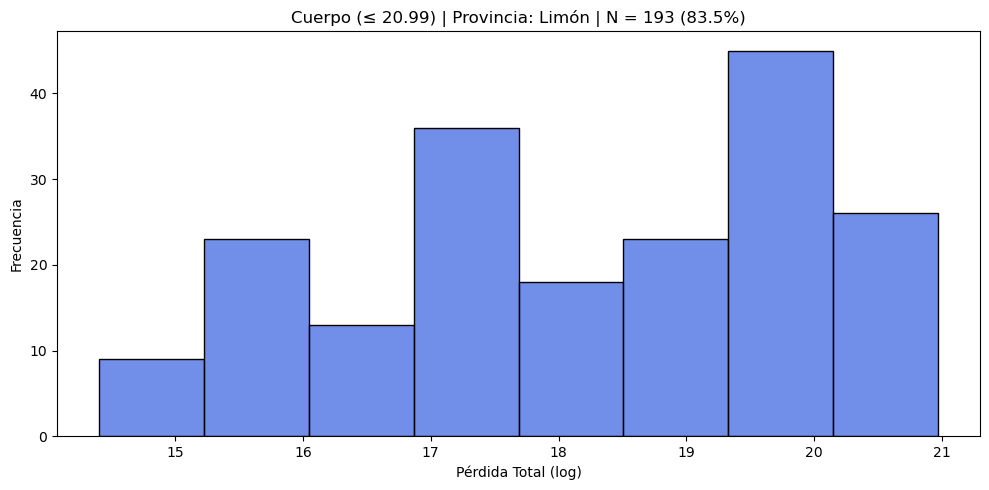

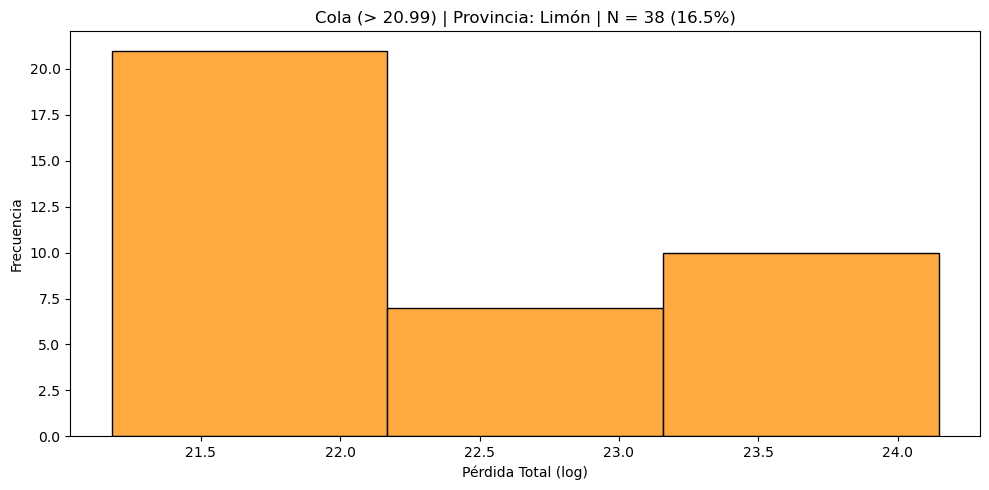


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.19
[Alerta] p-valor de KS es bajo: 0.0199. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.52
[Alerta] p-valor de KS es bajo: 0.0400. El ajuste podría no ser bueno.

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.02
[Alerta] p-valor de KS es bajo: 0.0049. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.60
[Alerta] p-valor de KS es bajo: 0.0266. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p         AIC         BIC
0           Weibull  Paramétrico  0.039984  763.353628  763.334476
1              Fisk  Paramétrico  0.026647  796.424894  796.407650
2             Gamma  Paramétrico  0.019920  792.543965  792.527591
3        KDE-tophat          KDE  0.019132  727.566314  730.829004
4  KDE-epanechnikov          KDE  0.019132  709.156458  712.419148
5   KDE-exponential   

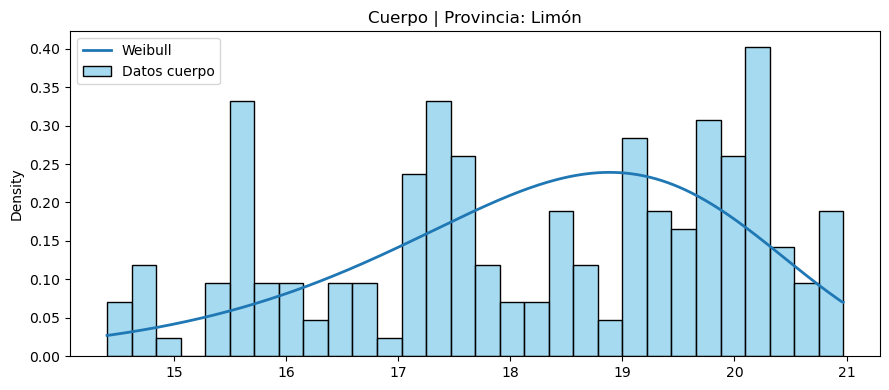

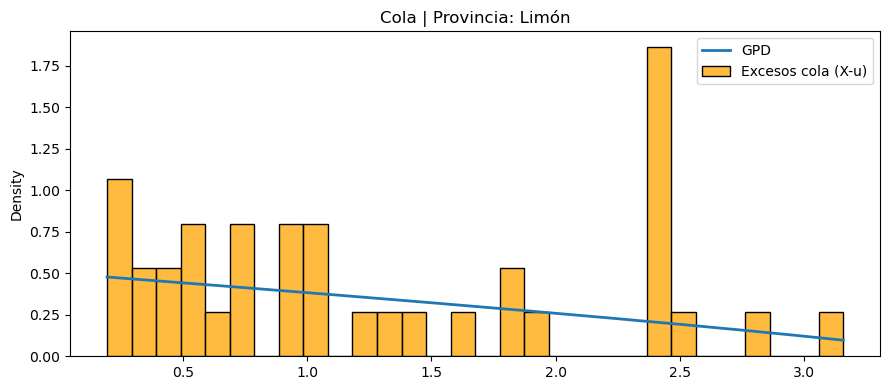

Análisis por consenso para la provincia Alajuela
El úmbral óptimo para Alajuela es 20.324
Número de datos en la cola: 70
Porcentaje de datos en la cola: 19.28%


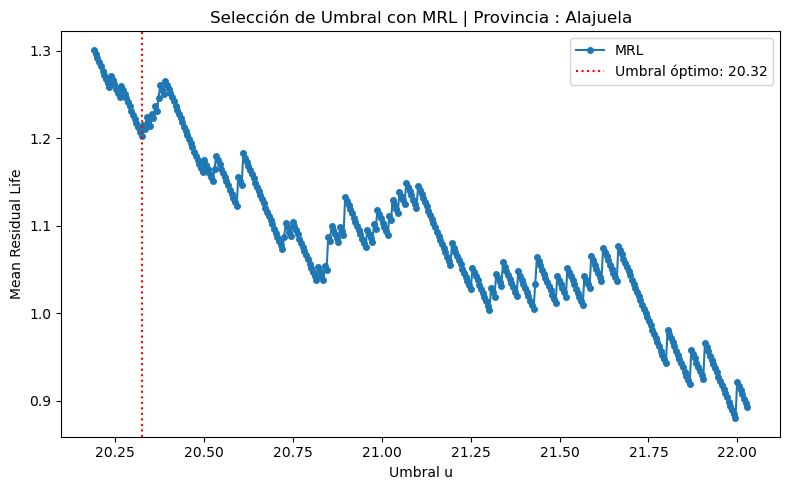

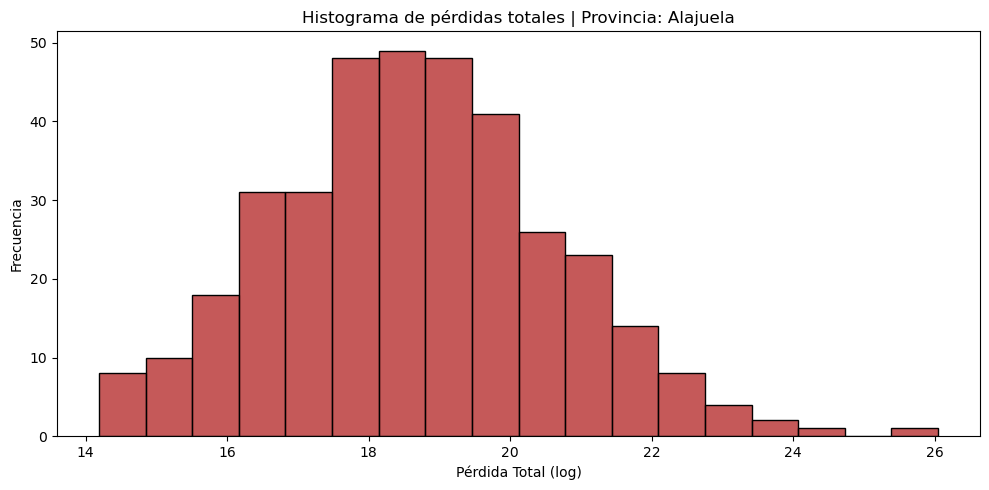

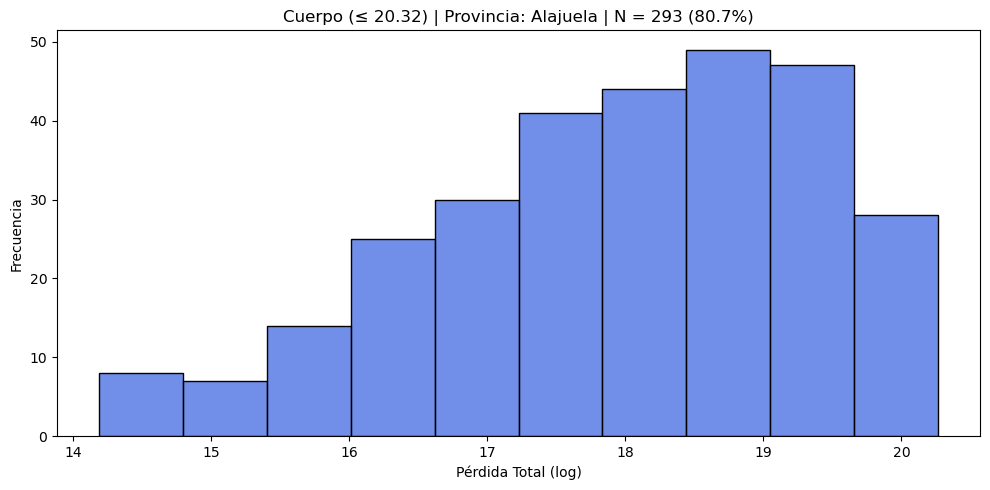

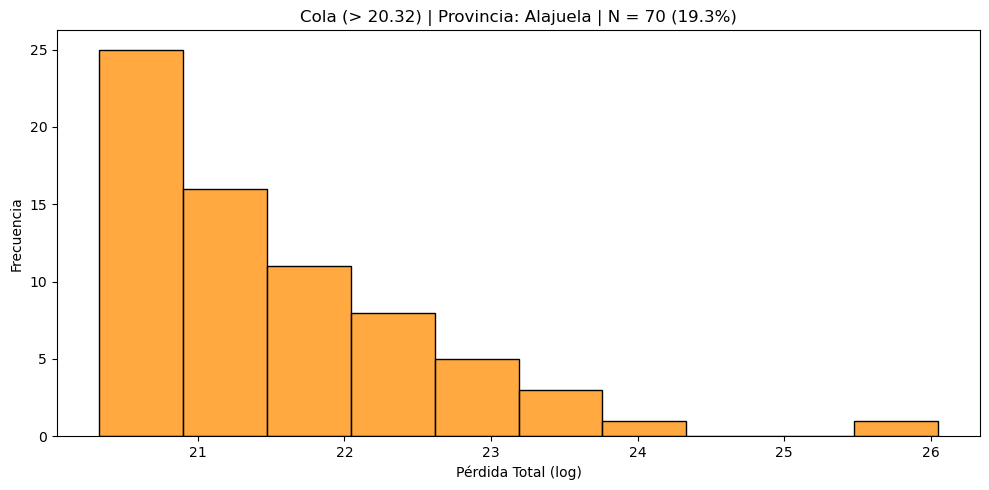


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.18
[Alerta] p-valor de KS es bajo: 0.0010. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.38

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.01

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.45

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p          AIC          BIC
0   KDE-exponential          KDE  0.500222  1021.025881  1024.706054
1           Weibull  Paramétrico  0.380810  1015.583119  1015.567947
2        KDE-tophat          KDE  0.334458   998.445403  1002.125575
3  KDE-epanechnikov          KDE  0.209976   992.452076   996.132249
4         Lognormal  Paramétrico  0.071399  1053.548012  1053.496648
5              Fisk  Paramétrico  0.059295  1061.119260  1061.114890
6      KDE-gaussian          KDE  0.037024  1011.564558  1015.244731
7             Gamma  Paramétrico  0.001041  1083.674312  1083.658247

 Ajustando cola

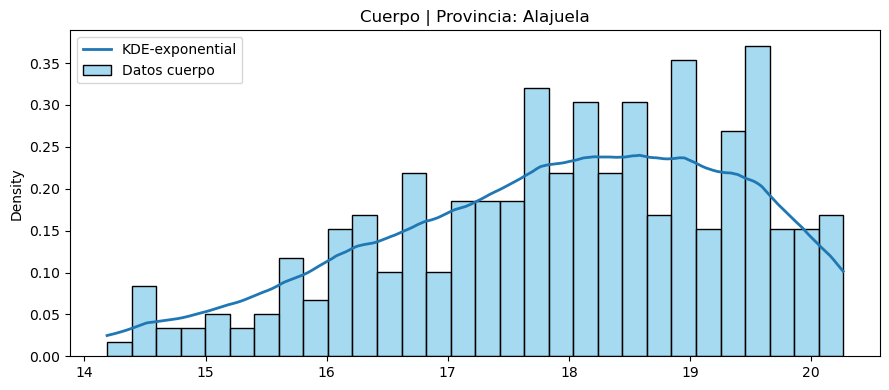

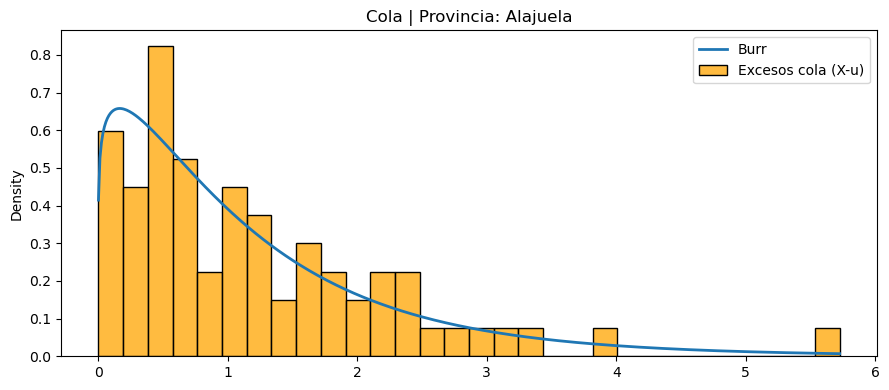

Análisis por consenso para la provincia Guanacaste
El úmbral óptimo para Guanacaste es 20.392
Número de datos en la cola: 81
Porcentaje de datos en la cola: 19.01%


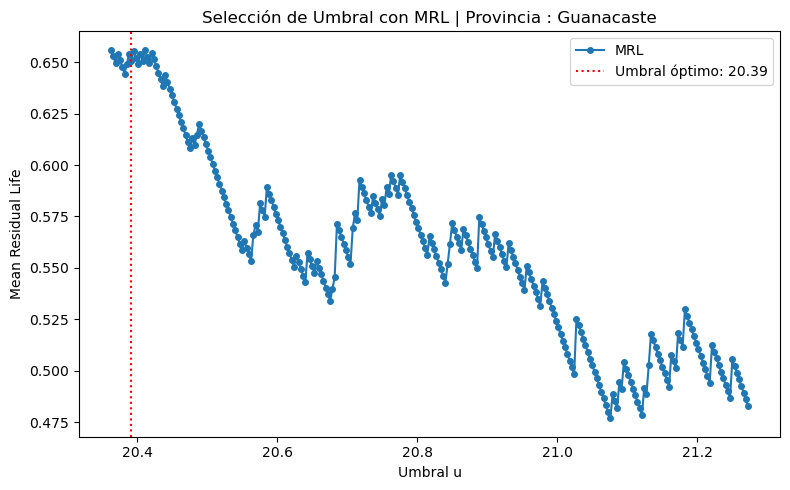

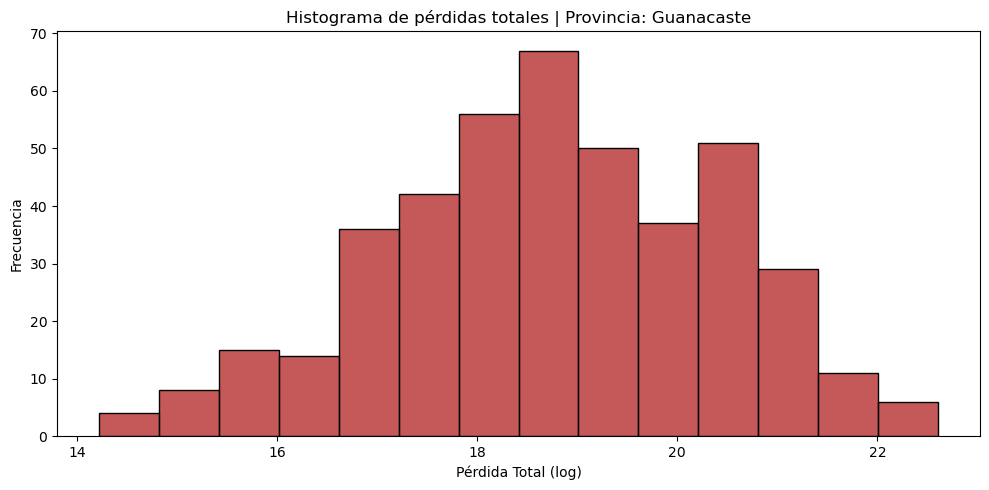

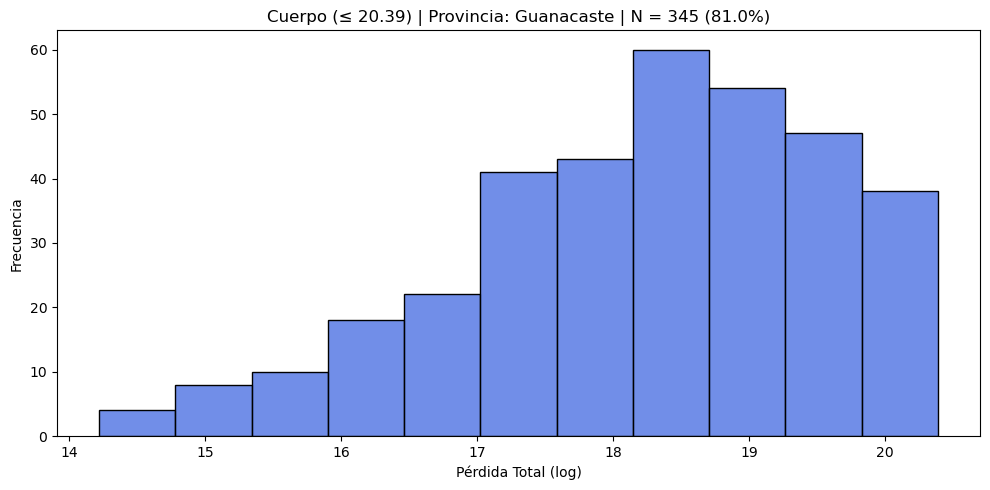

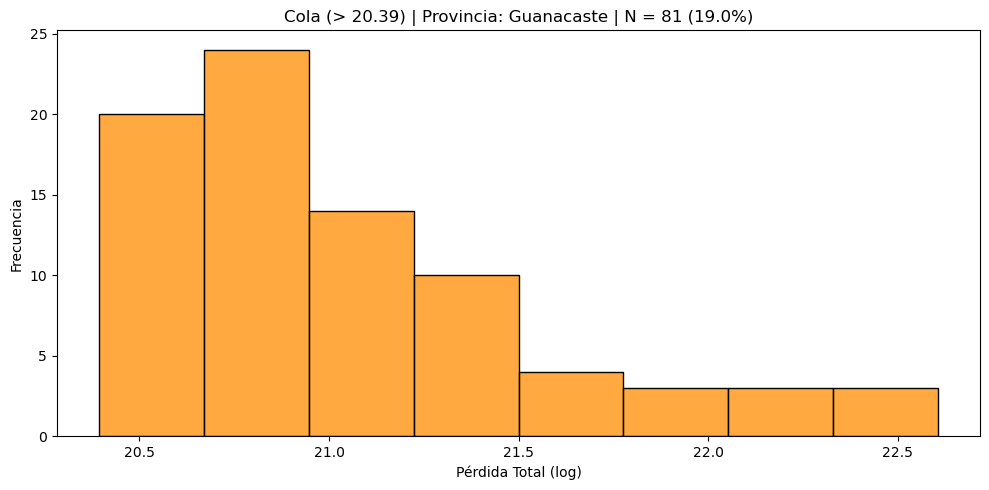


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.16
[Alerta] p-valor de KS es bajo: 0.0001. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.34

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.00
[Alerta] p-valor de KS es bajo: 0.0159. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.40
[Alerta] p-valor de KS es bajo: 0.0387. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p          AIC          BIC
0  KDE-epanechnikov          KDE  0.696817  1138.605790  1142.449335
1           Weibull  Paramétrico  0.583526  1158.523125  1158.507062
2        KDE-tophat          KDE  0.237387  1149.437224  1153.280768
3      KDE-gaussian          KDE  0.088997  1160.450029  1164.293573
4              Fisk  Paramétrico  0.038675  1208.362364  1208.366622
5         Lognormal  Paramétrico  0.015926  1207.238951  1207.191744
6   KDE-expo

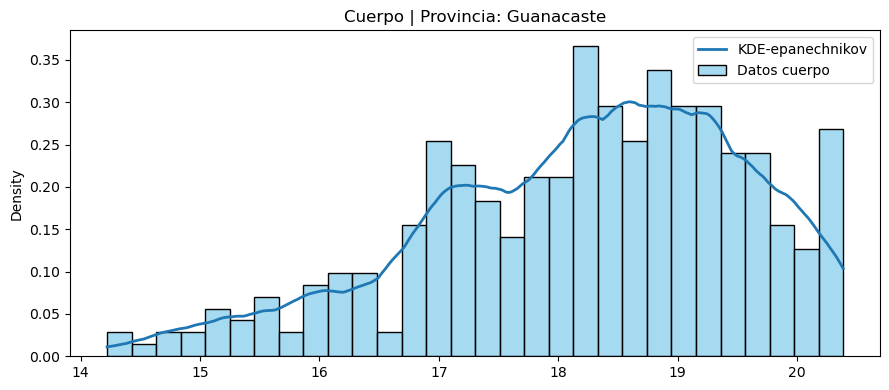

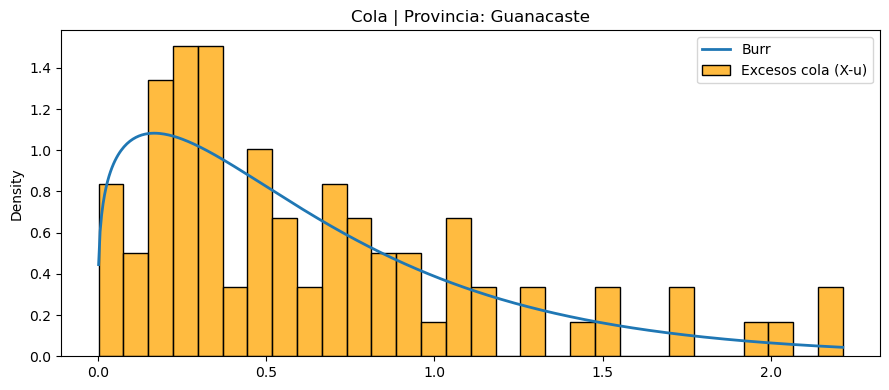

Análisis por consenso para la provincia Puntarenas
El úmbral óptimo para Puntarenas es 21.113
Número de datos en la cola: 85
Porcentaje de datos en la cola: 18.60%


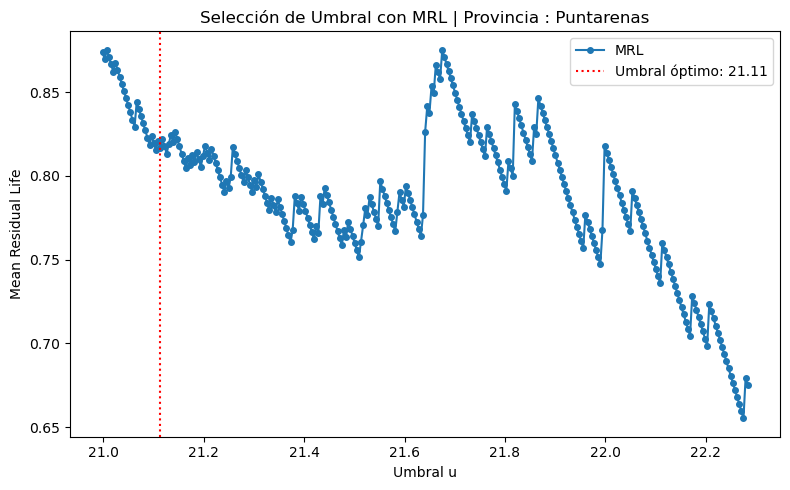

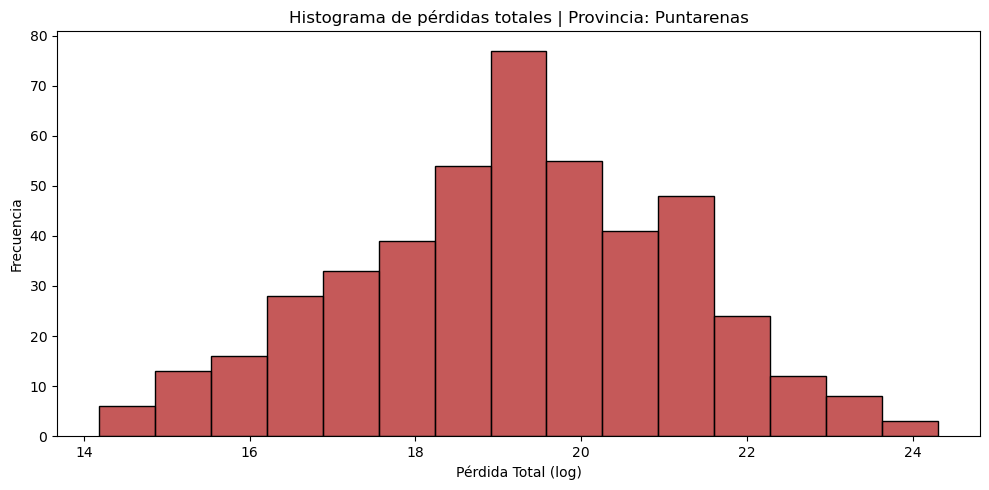

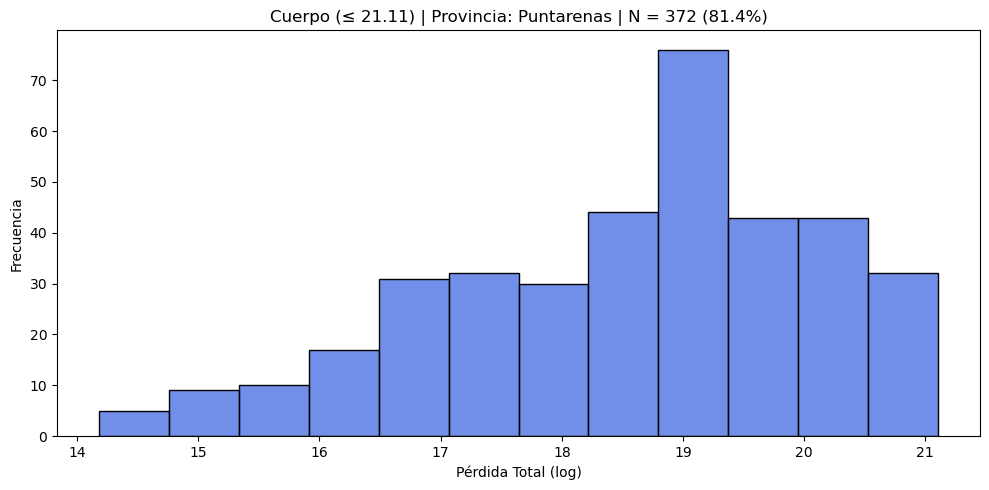

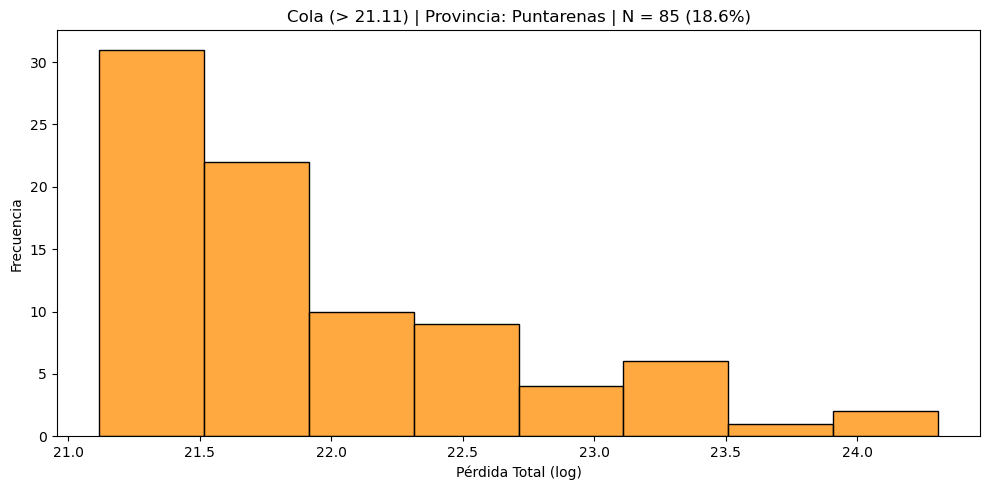


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.15
[Alerta] p-valor de KS es bajo: 0.0002. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.37

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.01
[Alerta] p-valor de KS es bajo: 0.0001. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.43
[Alerta] p-valor de KS es bajo: 0.0230. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p          AIC          BIC
0      KDE-gaussian          KDE  0.566783  1350.122870  1354.041764
1           Weibull  Paramétrico  0.482279  1351.901704  1351.887377
2        KDE-tophat          KDE  0.179702  1334.995179  1338.914073
3              Fisk  Paramétrico  0.022966  1411.469256  1411.468120
4   KDE-exponential          KDE  0.020572  1360.906306  1364.825200
5  KDE-epanechnikov          KDE  0.005366  1322.728261  1326.647155
6           

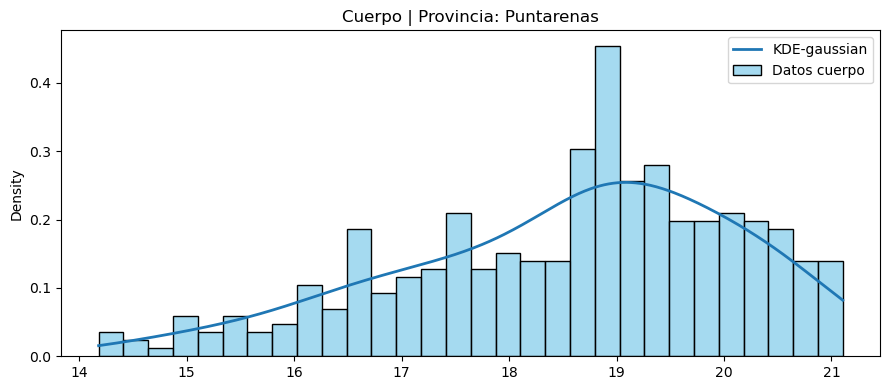

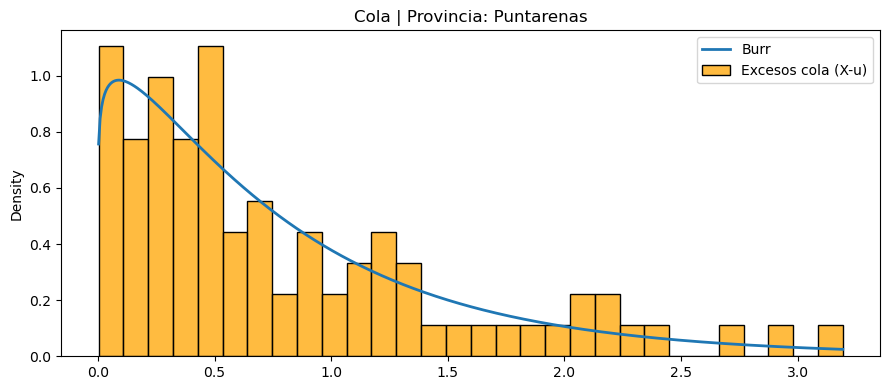

Análisis por consenso para la provincia San José
El úmbral óptimo para San José es 20.406
Número de datos en la cola: 91
Porcentaje de datos en la cola: 19.40%


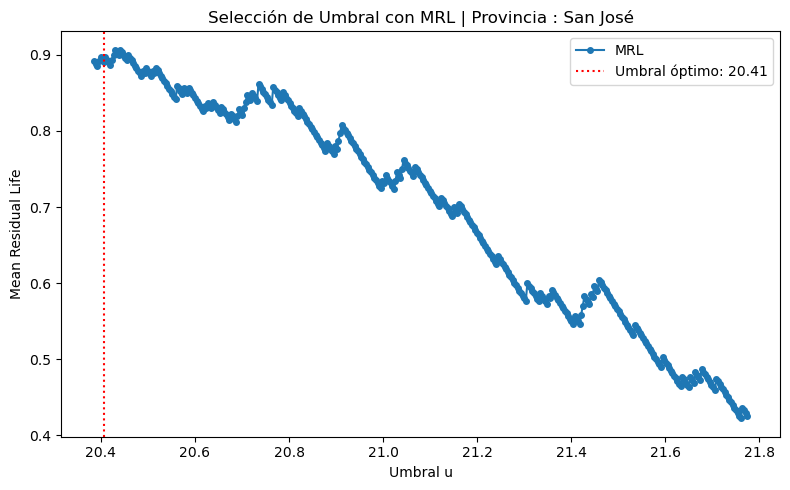

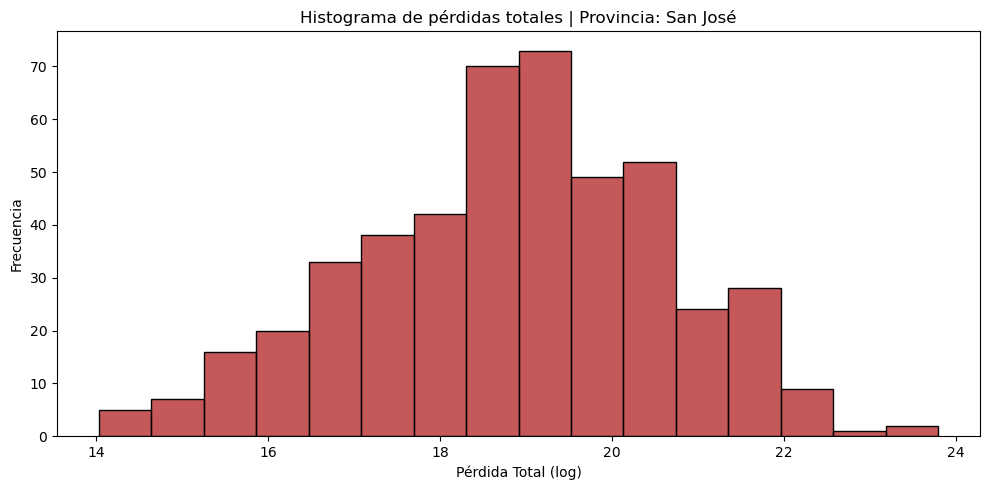

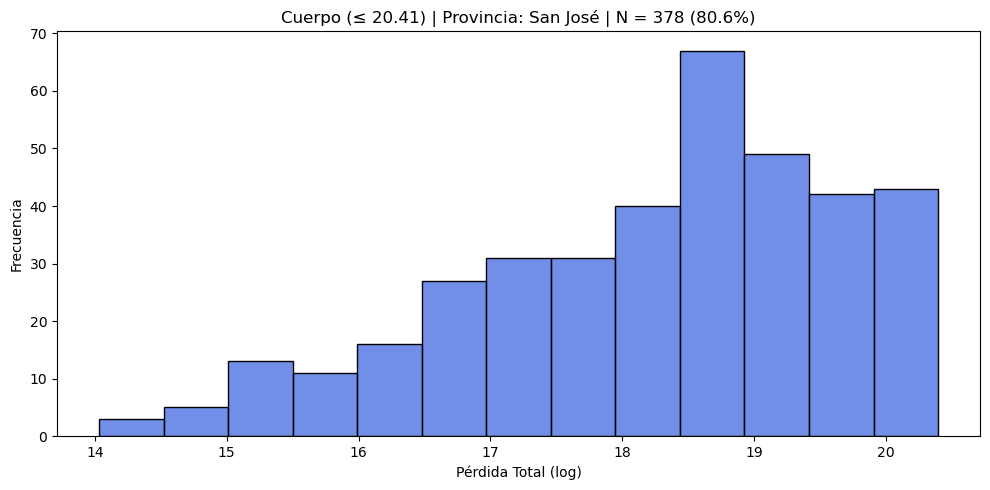

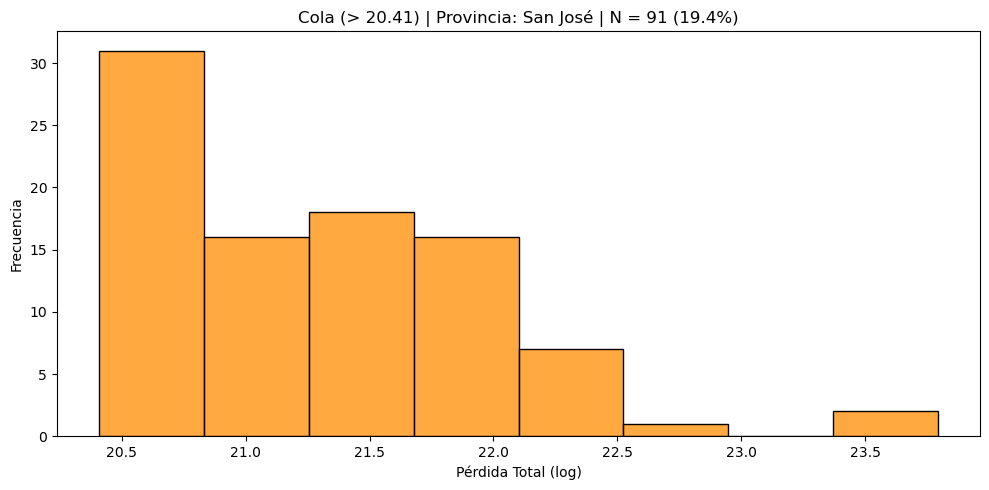


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.16
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.34

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.00
[Alerta] p-valor de KS es bajo: 0.0005. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.40
[Alerta] p-valor de KS es bajo: 0.0073. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p          AIC          BIC
0           Weibull  Paramétrico  0.285056  1292.337449  1292.326739
1        KDE-tophat          KDE  0.148473  1271.891999  1275.826893
2      KDE-gaussian          KDE  0.070005  1290.047336  1293.982230
3  KDE-epanechnikov          KDE  0.040204  1257.375507  1261.310402
4              Fisk  Paramétrico  0.007342  1360.060391  1360.055546
5   KDE-exponential          KDE  0.004125  1299.765828  1303.700723
6         Lo

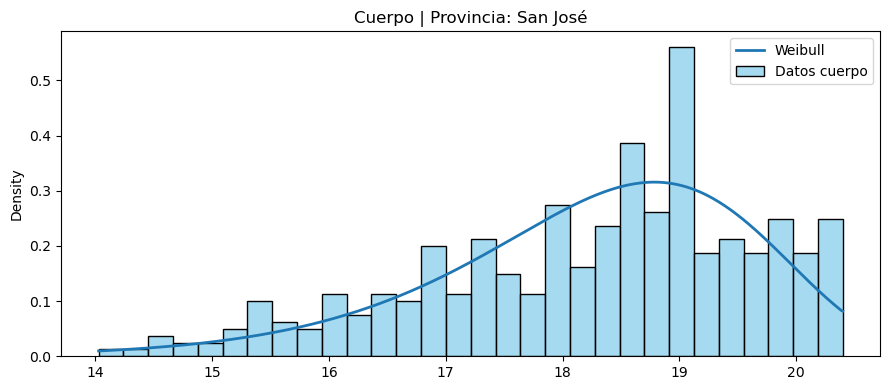

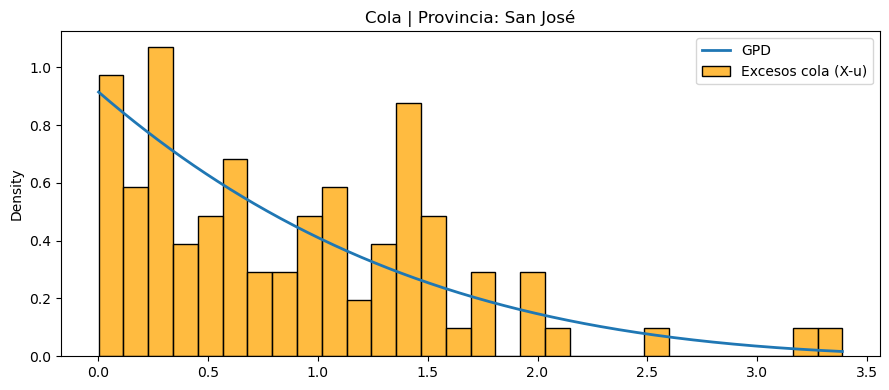

In [16]:
resultados_provincia = {}
for name in df['provincia'].unique():
    res = pipeline(df, provincia=name,n_iter=20000, burn=4000, seed=2025)

Análisis por consenso para el sector INFRAESTRUCTURA
El úmbral óptimo para INFRAESTRUCTURA es 21.000
Número de datos en la cola: 158
Porcentaje de datos en la cola: 15.96%


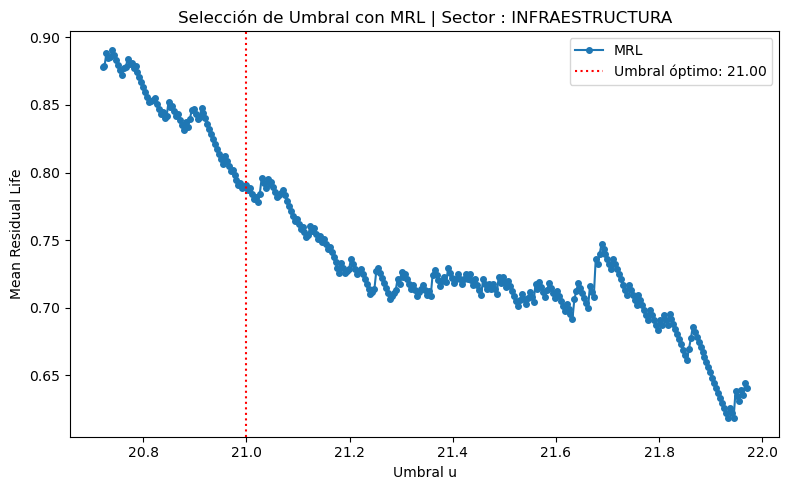

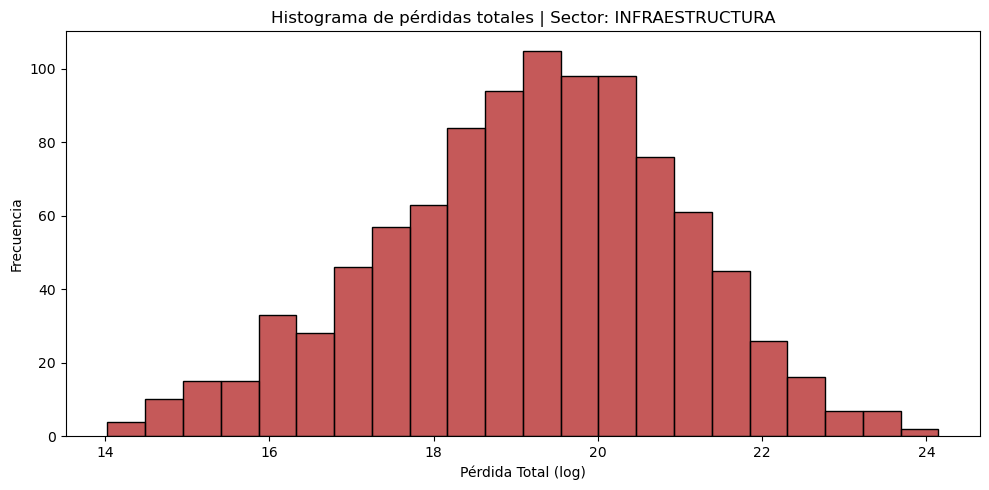

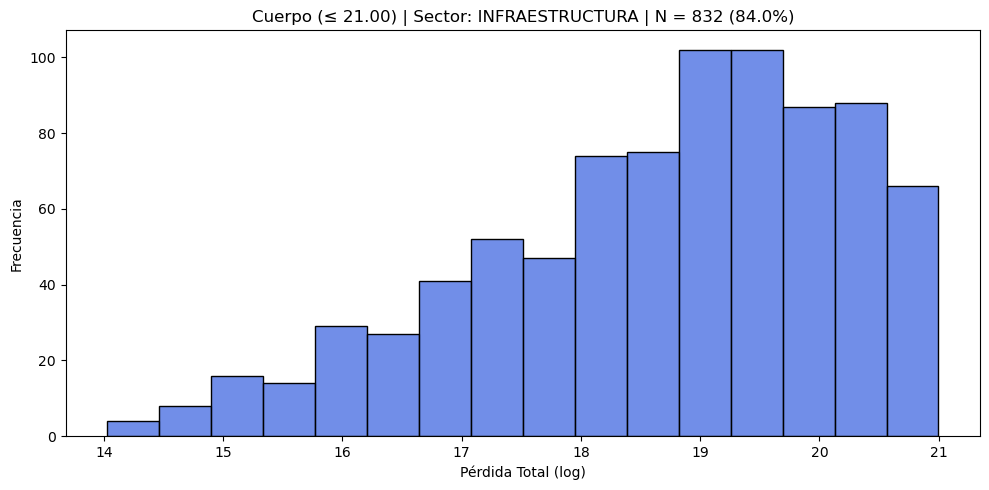

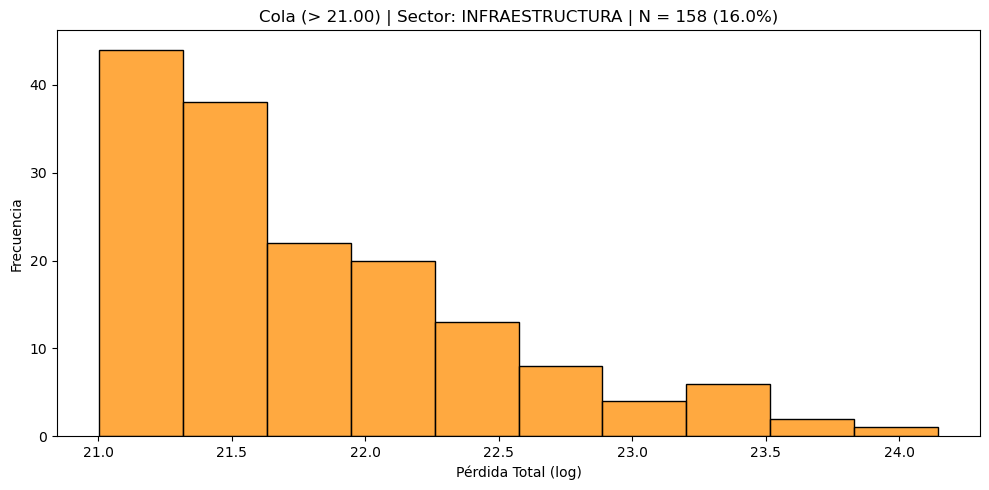


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.11
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.25

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.00
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.30
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo          KS_p          AIC          BIC
0  KDE-epanechnikov          KDE  7.128107e-01  2894.958604  2899.682437
1           Weibull  Paramétrico  1.727748e-01  2955.680538  2955.681873
2        KDE-tophat          KDE  1.208192e-01  2914.811494  2919.535326
3      KDE-gaussian          KDE  9.494968e-03  2955.978544  2960.702376
4   KDE-exponential          KDE  1.323145e-03  2989.173546  2993.897379
5              Fisk  Paramétrico  8.317875e-06  3115.1556

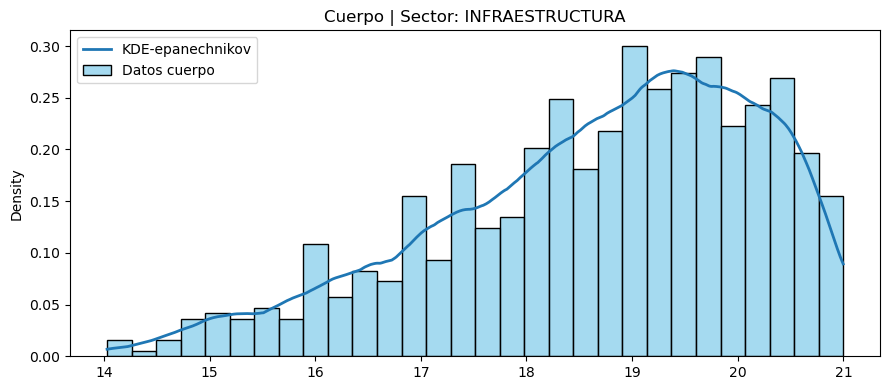

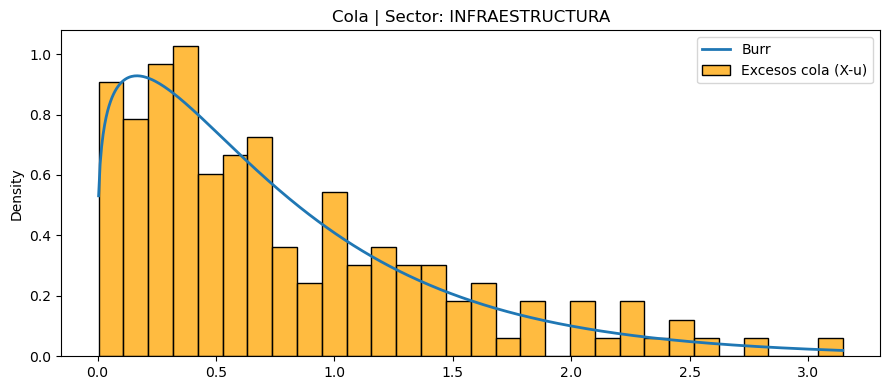

Análisis por consenso para el sector SOCIAL
El úmbral óptimo para SOCIAL es 20.139
Número de datos en la cola: 75
Porcentaje de datos en la cola: 18.34%


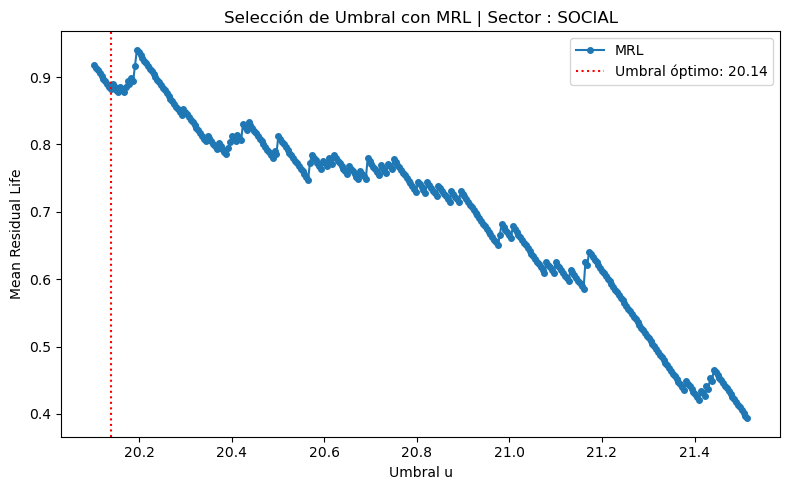

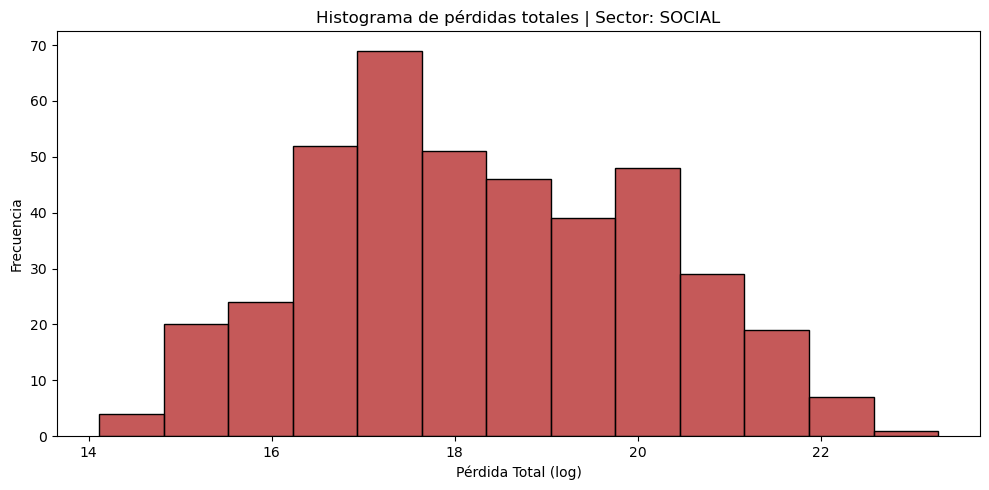

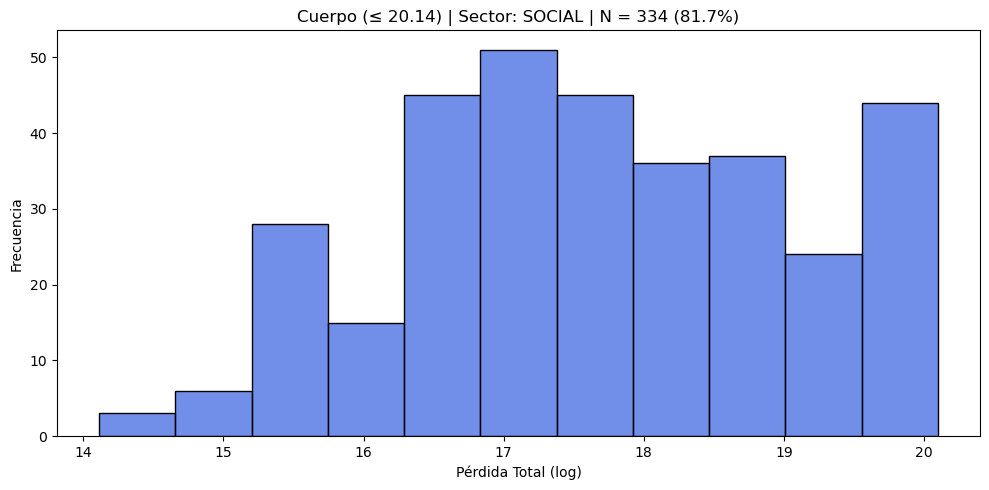

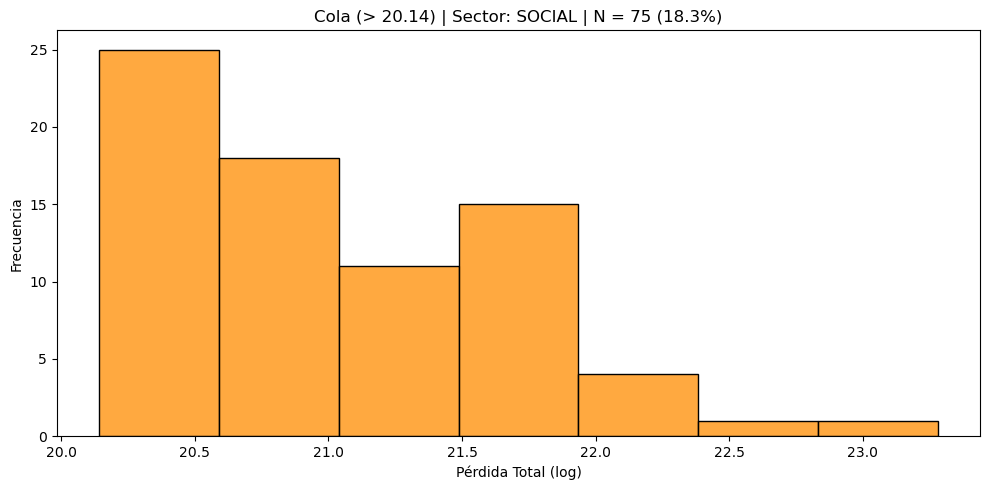


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.17
[Alerta] p-valor de KS es bajo: 0.0023. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.37
[Alerta] p-valor de KS es bajo: 0.0370. El ajuste podría no ser bueno.

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.01

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.42

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p          AIC          BIC
0  KDE-epanechnikov          KDE  0.496638  1115.293792  1119.104933
1         Lognormal  Paramétrico  0.340366  1168.624609  1168.593368
2              Fisk  Paramétrico  0.207036  1183.243408  1183.238653
3   KDE-exponential          KDE  0.174997  1149.958554  1153.769695
4        KDE-tophat          KDE  0.080317  1121.125074  1124.936215
5           Weibull  Paramétrico  0.037028  1174.584382  1174.569617
6      KDE-gaussian          KDE  0.004042  1144.829184  1148.640325
7             

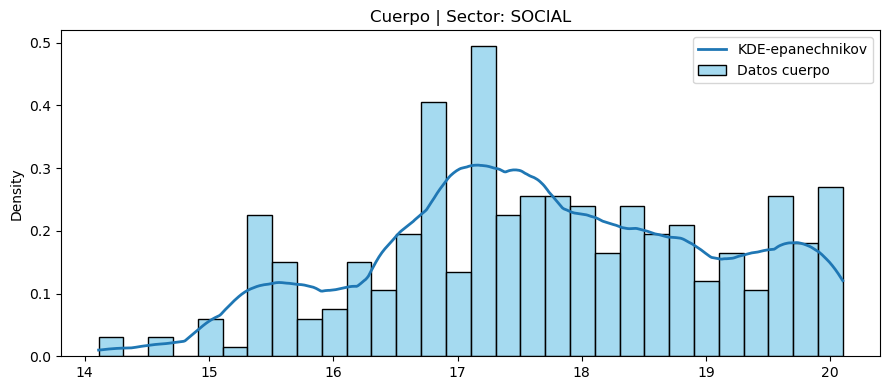

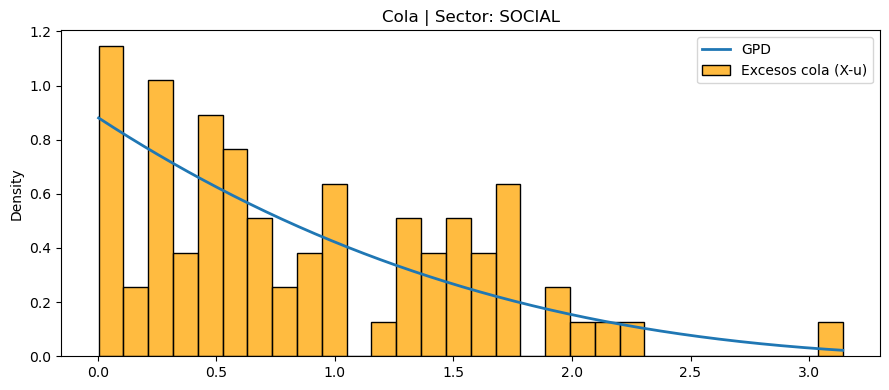

Análisis por consenso para el sector OTROS
El úmbral óptimo para OTROS es 20.917
Número de datos en la cola: 67
Porcentaje de datos en la cola: 18.46%


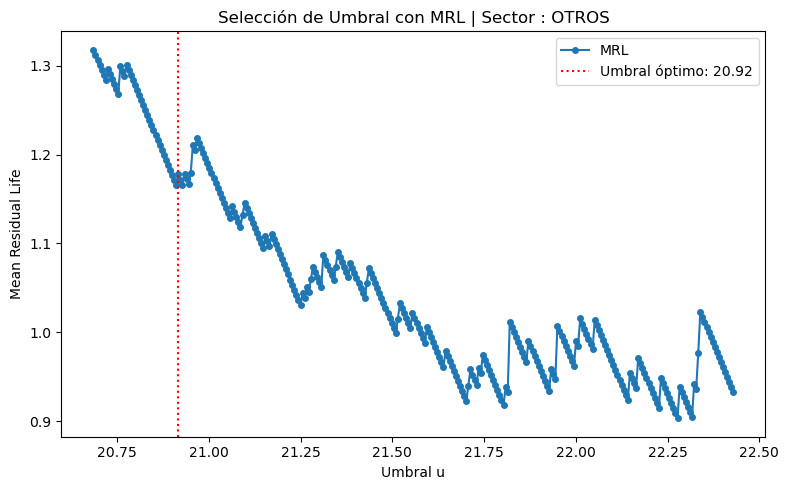

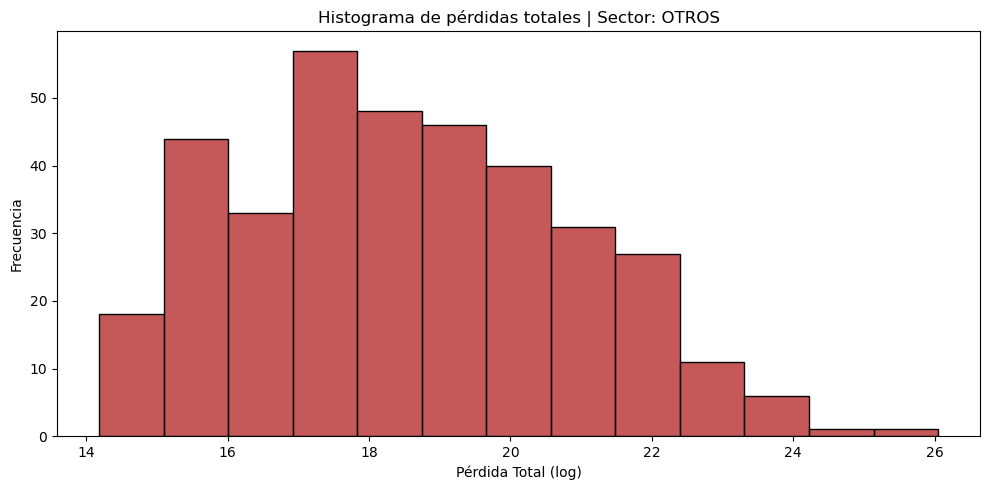

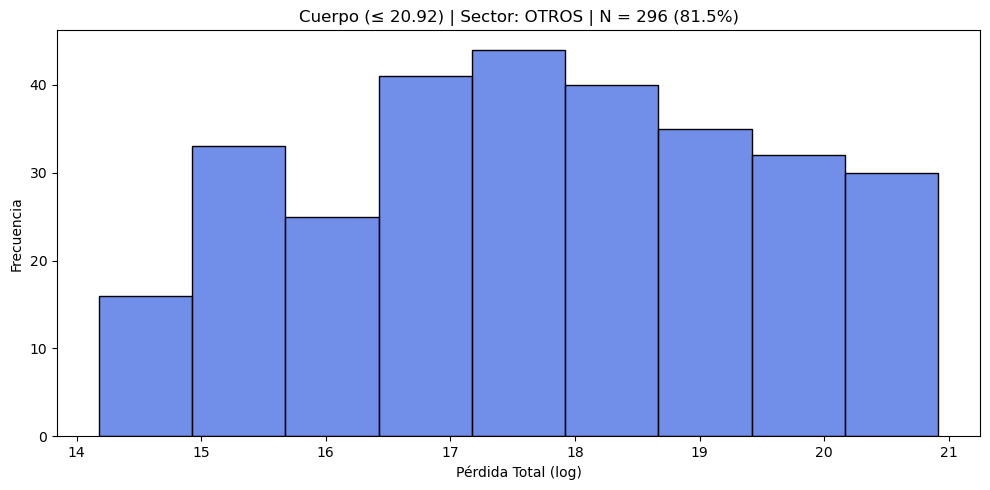

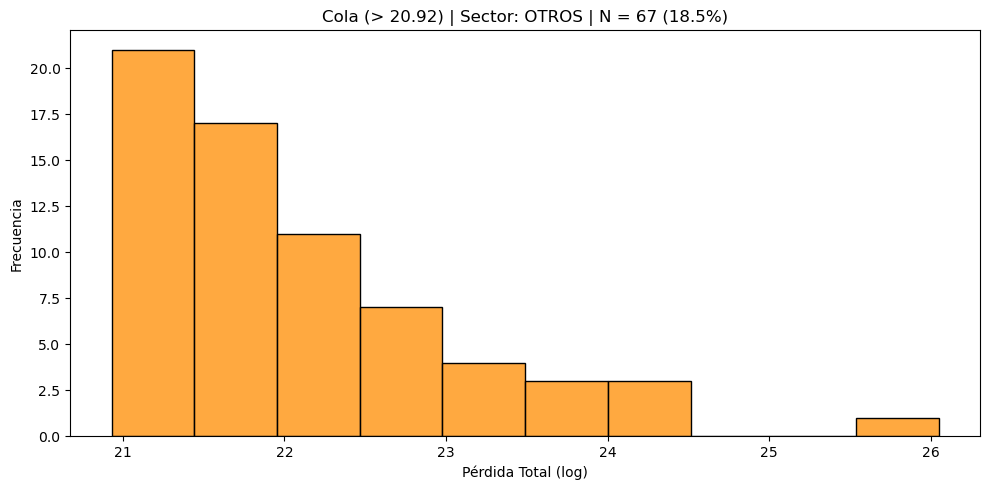


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.16

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.45

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.01

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.51

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo      KS_p          AIC          BIC
0   KDE-exponential          KDE  0.340472  1152.713856  1156.404216
1  KDE-epanechnikov          KDE  0.272438  1115.451286  1119.141645
2           Weibull  Paramétrico  0.188151  1173.833125  1173.815211
3              Fisk  Paramétrico  0.179758  1192.954210  1192.940096
4         Lognormal  Paramétrico  0.158462  1173.081268  1173.068055
5             Gamma  Paramétrico  0.064933  1190.621851  1190.595069
6        KDE-tophat          KDE  0.038555  1138.008116  1141.698476
7      KDE-gaussian          KDE  0.038555  1145.625815  1149.316174

 Ajustando cola: GPD
Tasa aceptación GPD: 0.21

 Ajustando cola: Burr
Tasa aceptación 

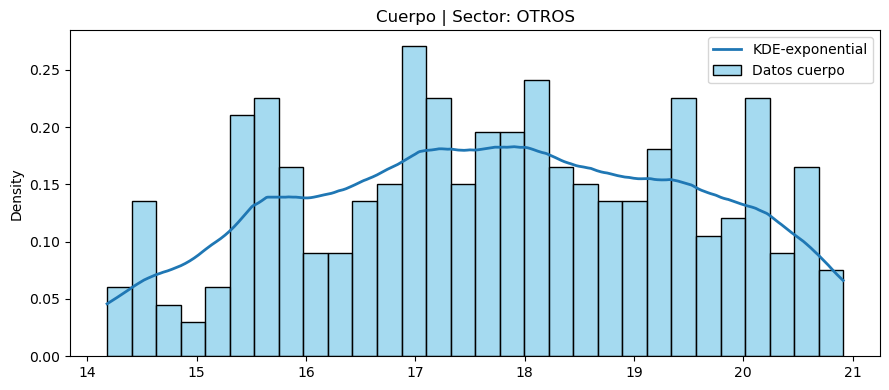

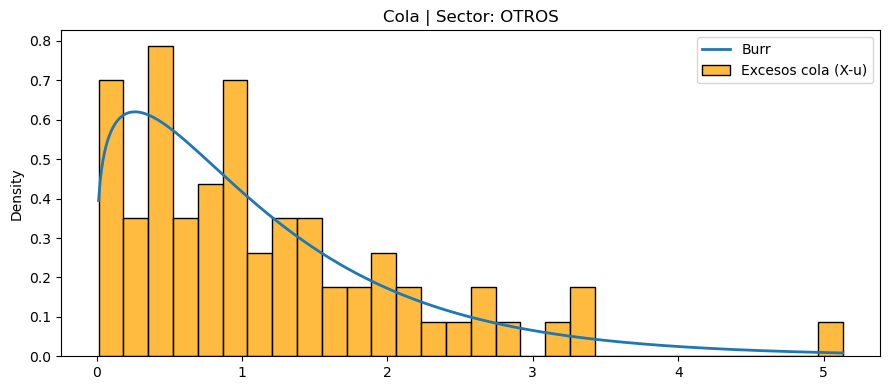

Análisis por consenso para el sector HÍDRICO
El úmbral óptimo para HÍDRICO es 20.268
Número de datos en la cola: 37
Porcentaje de datos en la cola: 17.29%


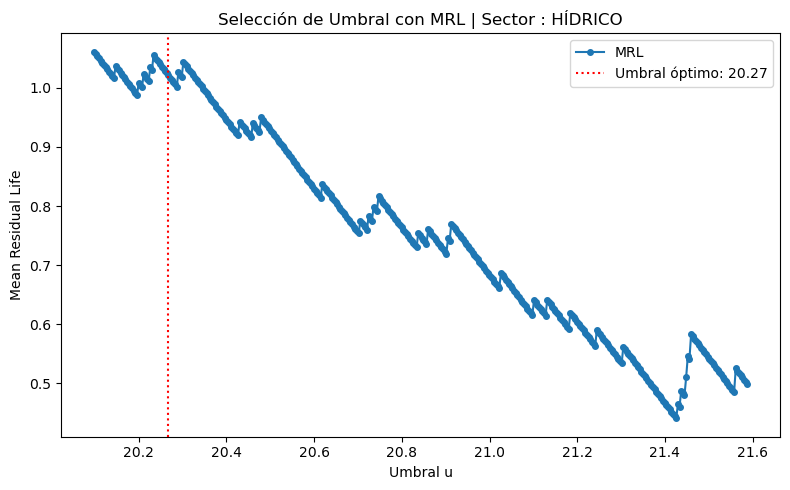

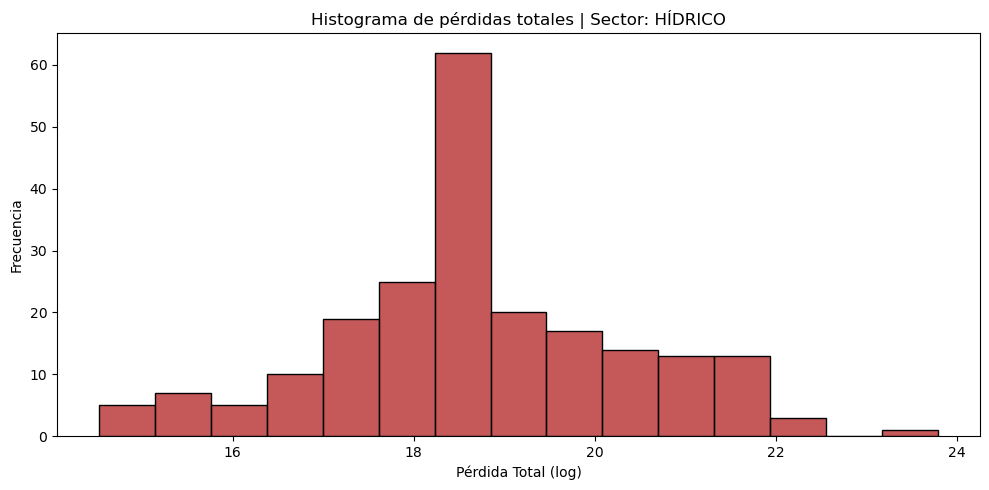

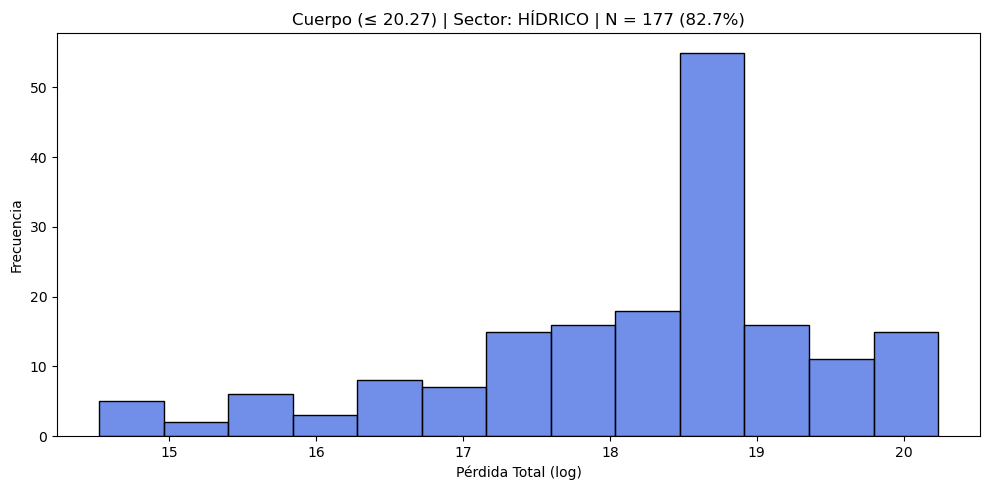

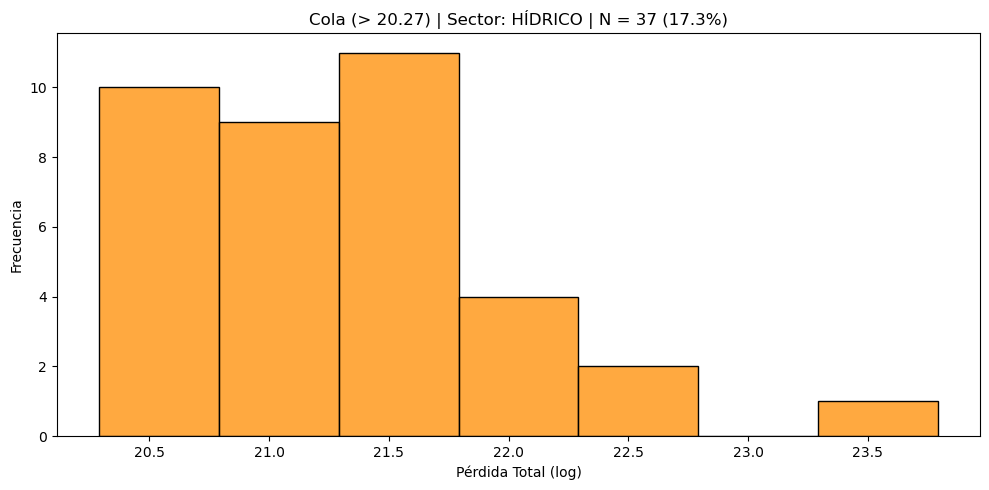


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.22
[Alerta] p-valor de KS es bajo: 0.0011. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.41
[Alerta] p-valor de KS es bajo: 0.0086. El ajuste podría no ser bueno.

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.01
[Alerta] p-valor de KS es bajo: 0.0001. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.47
[Alerta] p-valor de KS es bajo: 0.0012. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo          KS_p         AIC         BIC
0           Weibull  Paramétrico  8.632784e-03  558.348633  558.317284
1  KDE-epanechnikov          KDE  7.665718e-03  518.319631  521.495781
2              Fisk  Paramétrico  1.225538e-03  585.030263  584.996817
3             Gamma  Paramétrico  1.139399e-03  638.323314  638.292027
4      KDE-gaussian          KDE  8.492575e-04  547.752996  550.92914

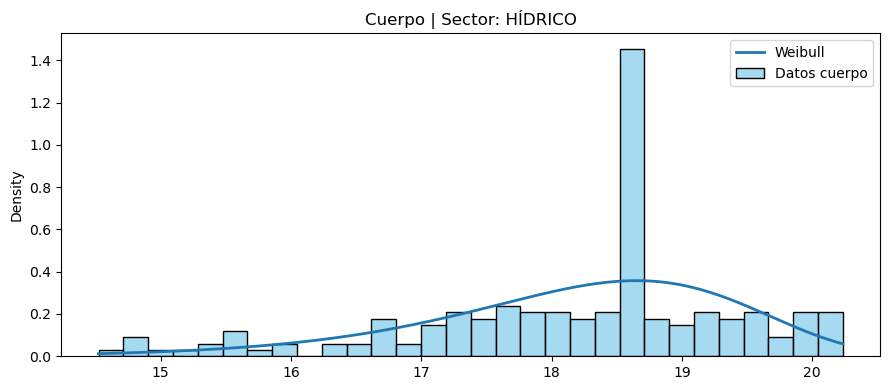

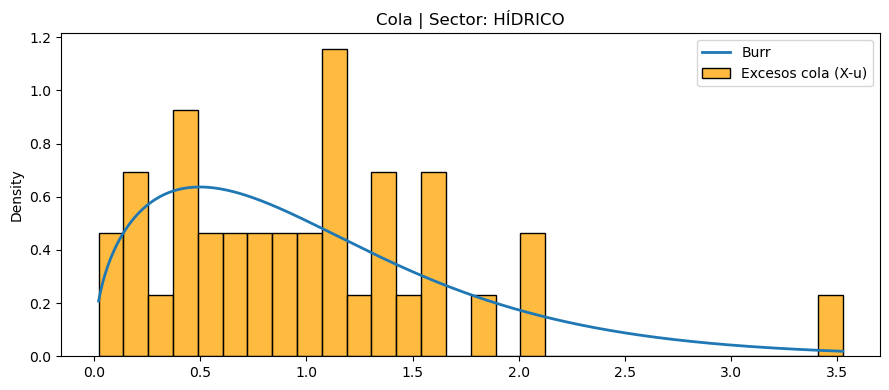

Análisis por consenso para el sector PRODUCTIVO
El úmbral óptimo para PRODUCTIVO es 19.855
Número de datos en la cola: 48
Porcentaje de datos en la cola: 18.18%


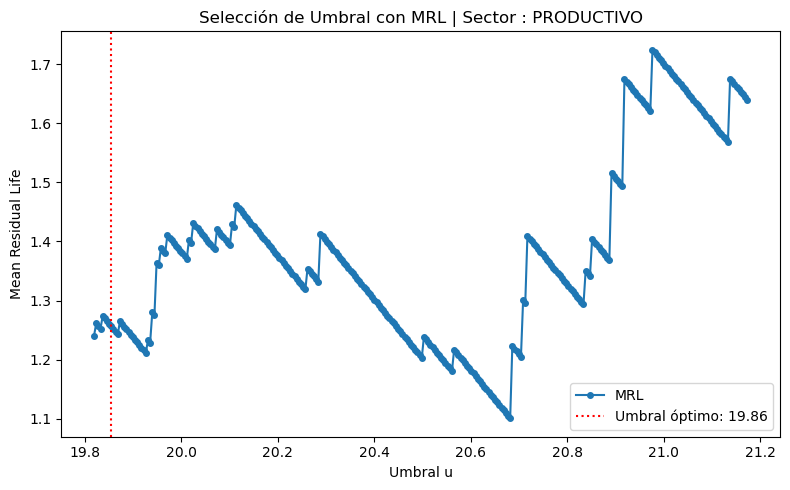

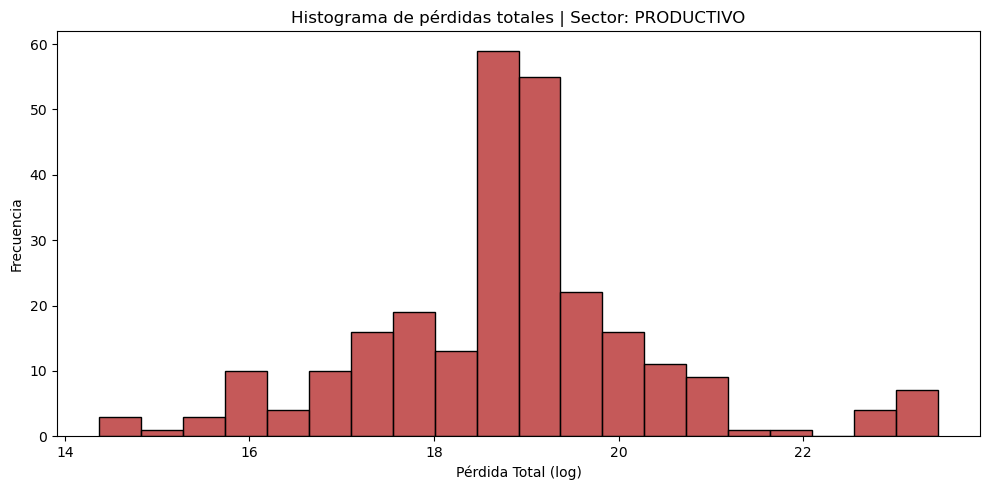

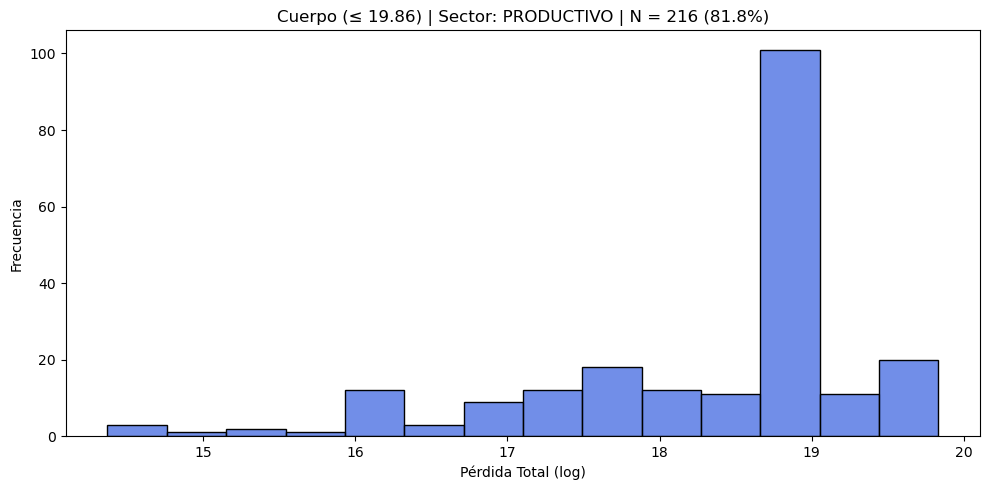

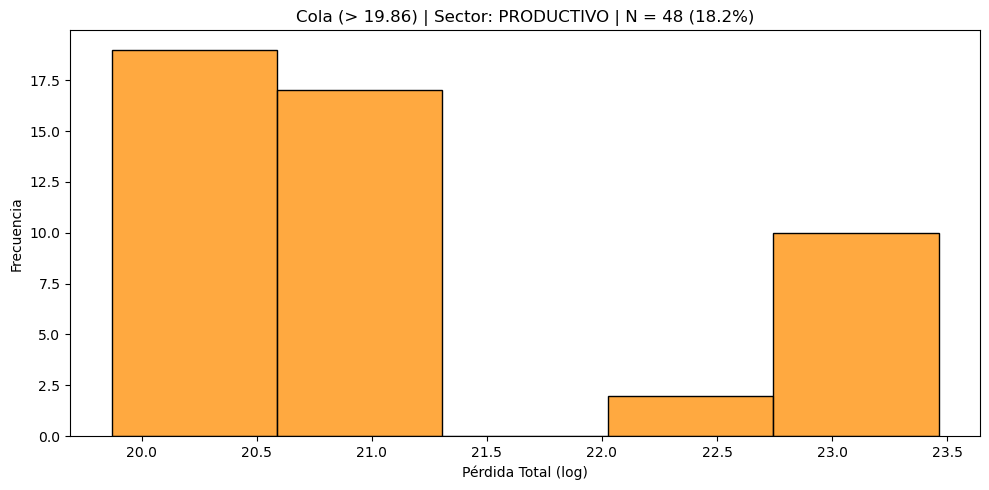


 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.20
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.32
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.01
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.40
[Alerta] p-valor de KS es bajo: 0.0000. El ajuste podría no ser bueno.

Tabla completa modelos CUERPO (paramétricos + KDE):
              modelo         tipo          KS_p         AIC         BIC
0        KDE-tophat          KDE  2.460144e-08  559.337753  562.713031
1             Gamma  Paramétrico  8.196382e-09  755.763136  755.709786
2   KDE-exponential          KDE  4.473574e-09  540.525663  543.900942
3      KDE-gaussian          KDE  1.852184e-09  567.509572  570.884850
4              Fisk  Paramétrico  1.142660e-10  666.064545  666.04878

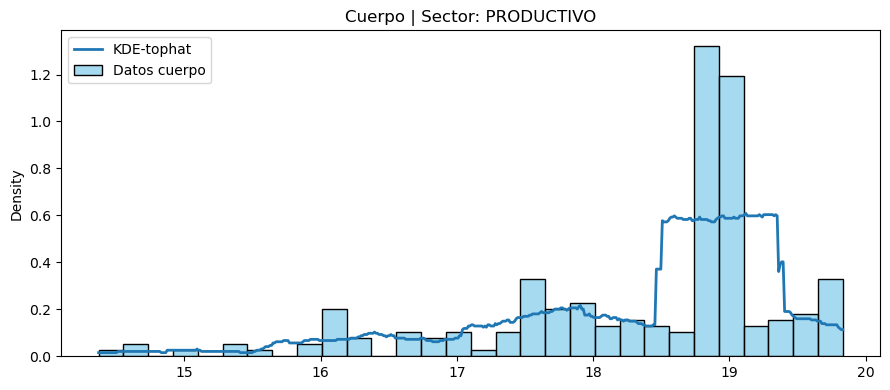

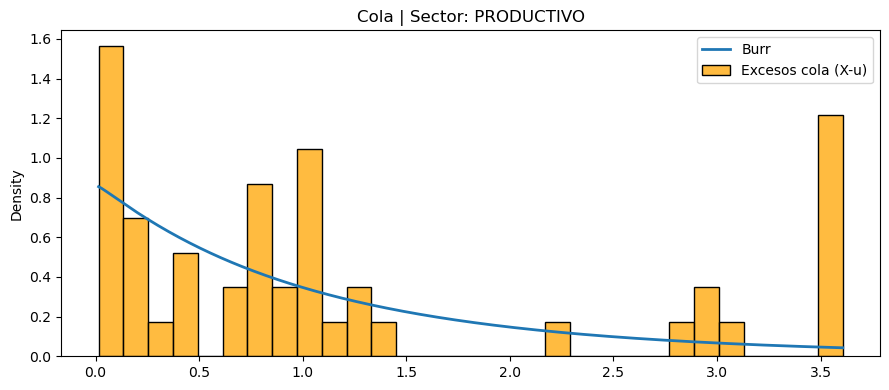

In [17]:
resultados_sector = {}
for name in df['sector'].unique():
    res = pipeline(df, sector=name,n_iter=20000, burn=4000, seed=2025)